# Projet 08 : Communiquer des résultats
# Partie 1 : Préparation des données

---

## <font color=blue>Sommaire</font>

[1. Exploration des données utilisées](#1_0)   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1. Première approche des données](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2. Décomptage des signaux](#1_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3. Agrégation des signaux](#1_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4. Préparation d'un dataframe avec l'évolution future des prix à partir d'une date donnée](#1_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.5. Sauvegarde des dataframes pour la suite du projet](#1_5)  

---
**Importation des librairies**

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

import modules_perso.sf_graphiques as sfg
import modules_perso.sf_classification_acp as sfca

<a id='1_0'></a>

---
## <font color=blue>Mission 1 : Exploration des données utilisées</font>

### 1.1. Première approche des données

In [4]:
contracts = pd.read_csv("data_contract_names.csv", sep=";", index_col=0)
contracts.head()

,name,currency
contract_id,,
1,AUD,USD
2,CAD,USD
3,CHF,USD
4,EuroFx,USD
5,GBP,USD


In [5]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 1 to 92
Data columns (total 2 columns):
name        51 non-null object
currency    51 non-null object
dtypes: object(2)
memory usage: 1.2+ KB


In [6]:
prices = pd.read_csv("data_contract_prices.csv", sep=";", decimal=",", parse_dates=["dateref"], index_col=[0,1])
prices.head()

close_price  mid_price  real_price
contract_id dateref                                       
1           1989-11-01        28.12     28.070       75.50
            1989-11-02        27.79     27.905       75.17
            1989-11-03        28.05     27.935       75.43
            1989-11-06        28.45     28.360       75.83
            1989-11-07        28.52     28.570       75.90

In [7]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360539 entries, (1, 1989-11-01 00:00:00) to (92, 2019-11-14 00:00:00)
Data columns (total 3 columns):
close_price    360539 non-null float64
mid_price      360539 non-null float64
real_price     360539 non-null float64
dtypes: float64(3)
memory usage: 9.3 MB


In [8]:
signals = pd.read_csv("data_signals.csv", parse_dates=["dateref"])
signals.head()

,category_name,contract_id,dateref,trading_indicator,param_time_period,snl_signal
0,STIR,27,1999-01-12,BRO,MT1,0
1,STIR,27,1999-01-12,BRO,MT1,0
2,STIR,27,1999-01-12,BRO,MT1,0
3,STIR,27,1999-01-12,BRO,MT1,0
4,STIR,27,1999-01-12,BRO,MT1,0


In [9]:
signals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162021150 entries, 0 to 162021149
Data columns (total 6 columns):
category_name        object
contract_id          int64
dateref              datetime64[ns]
trading_indicator    object
param_time_period    object
snl_signal           int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 7.2+ GB


In [10]:
categorie_contrat = signals.groupby("contract_id").category_name.max().reset_index()
categorie_contrat.head()

,contract_id,category_name
0,1,Currencies
1,2,Currencies
2,3,Currencies
3,4,Currencies
4,5,Currencies


In [11]:
signals[["trading_indicator","snl_signal"]].groupby("trading_indicator").count()

,snl_signal
trading_indicator,
BRO,54007050
FOT,54007050
MOM,54007050


Nous avons autant de signaux pour chaque indicateur de trading. Vérification OK.

In [12]:
signals[["param_time_period","snl_signal"]].groupby("param_time_period").count()

,snl_signal
param_time_period,
LT1,27003525
LT2,27003525
LT3,27003525
MT1,27003525
MT2,27003525
MT3,27003525


Nous avons autant de signaux pour chaque horizon temporel. Vérification OK.

In [13]:
signals_bycontract = signals[["contract_id","snl_signal"]].groupby("contract_id").count()
signals_bycontract

,snl_signal
contract_id,
1,3454650
2,3474450
3,3492900
4,2405700
5,3493350
6,3497850
7,2809350
9,3201750
10,3297150


Le nombre de signaux change selon les contrats. Il faut vérifier la cohérence avec les dates de début et de fin des données sur les prix, et le nombre de ces données.

In [14]:
verif_contract = contracts.copy()
verif_contract["date_debut"] = prices.reset_index().groupby("contract_id").dateref.min()
verif_contract["date_fin"] = prices.reset_index().groupby("contract_id").dateref.max()
verif_contract["nb_jours_donnees"] = prices.reset_index().groupby("contract_id").dateref.count()
verif_contract["nb_signaux_calcules"] = signals_bycontract.snl_signal
verif_contract

,name,currency,date_debut,date_fin,nb_jours_donnees,nb_signaux_calcules
contract_id,,,,,,
1,AUD,USD,1989-11-01,2019-11-14,7687,3454650
2,CAD,USD,1989-09-01,2019-11-14,7731,3474450
3,CHF,USD,1989-07-03,2019-11-14,7772,3492900
4,EuroFx,USD,1999-01-04,2019-11-14,5356,2405700
5,GBP,USD,1989-07-03,2019-11-14,7773,3493350
6,JPY,USD,1989-06-01,2019-11-14,7783,3497850
7,MXN,USD,1995-04-25,2019-11-14,6253,2809350
9,Bobl,EUR,1991-10-04,2019-11-14,7125,3201750
10,Bund,EUR,1990-11-23,2019-11-14,7337,3297150


Les dates de début et de fin de données sont cohérentes avec le nombre de données pour les prix et avec le nombre de signaux obtenus.

In [15]:
len(signals[signals.snl_signal==-1])

40540654

In [16]:
len(signals[signals.snl_signal==0])

44260547

In [17]:
len(signals[signals.snl_signal==1])

77219949

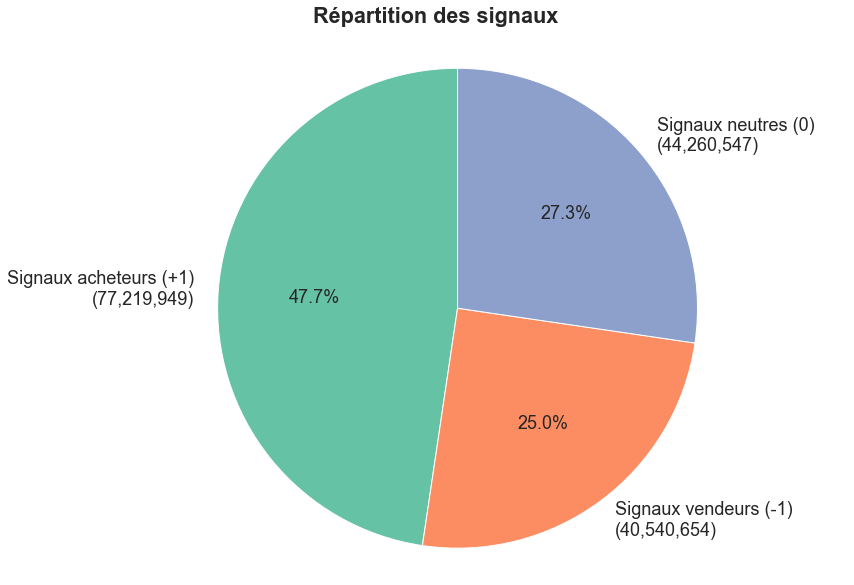

In [18]:
labels = ["Signaux acheteurs (+1)\n({:,.0f})".format(len(signals[signals.snl_signal==1])),\
          "Signaux vendeurs (-1)\n({:,.0f})".format(len(signals[signals.snl_signal==-1])),
          "Signaux neutres (0)\n({:,.0f})".format(len(signals[signals.snl_signal==0]))]
values = [len(signals[signals.snl_signal==1]),
          len(signals[signals.snl_signal==-1]),
          len(signals[signals.snl_signal==0])]
graph00 = sfg.MyGraph("Répartition des signaux", is_mono=False)
graph00.add_pie(values, labels)
fig, ax = graph00.fig, graph00.ax
plt.savefig("M1_repart_snl.png")
plt.show()

Il y a à peu près autant de signaux nuls et négatifs. Par contre, le nombre de signaux positifs est largement supérieur.  
Les signaux nuls correspondent à des phases où les marchés n'ont pas de tendance marquée. Ils sont dans des phases de consolidation ou d'hésitation.  
Le grand nombre de signaux positifs s'explique facilement par la structure générale des marchés. La plupart des marchés ont des phases haussières assez progressives et longues alors que les phases baissières sont souvent plus rapides et fortes.  
De plus, sur la période étudiée, tous les produits liés aux taux d'intérêt ont connu plusieurs grandes tendances haussières quasi-continues. Ces produits représentent 45% des contrats analysés (23 contrats sur 51) et biaisent donc le nombre de signaux positifs vers le haut.  
De la même manière, les indices boursiers ont connu plus d'années haussières que baissières sur la période étudiée. Même si certaines phases baissières ont été brusques en termes de variations, elles ont souvent été limitées dans le temps.

<a id='1_2'></a>

### 1.2. Décomptage des signaux

Répartition des signaux -1, 0 et 1 par catégorie de contrats ; par indicateur technique ; par horizon temporel ; par paire indicateur technique / horizon temporel  
Permet une analyse graphique

Ensuite analyser graphiquement lien entre somme signaux et évolution marchés

In [19]:
graph_data_01 = signals[["category_name","snl_signal","contract_id"]].groupby(["category_name","snl_signal"]).count()
graph_data_01.columns = ["nombre_signaux"]
graph_data_01

nombre_signaux
category_name snl_signal                
Currencies    -1                 7560213
               0                 6512182
               1                 8555855
Energy        -1                 6305668
               0                 5666948
               1                 7485834
Index         -1                 5723426
               0                 7959108
               1                15667366
LTIR          -1                 5165191
               0                 7833757
               1                16528702
Metals        -1                 6202581
               0                 5316755
               1                 5821864
STIR          -1                 9583575
               0                10971797
               1                23160328

In [20]:
graph_data_01.reset_index(inplace=True)
graph_data_01["total"] = graph_data_01.groupby("category_name").nombre_signaux.transform(pd.Series.sum)
graph_data_01["pourcentage_signaux"] = graph_data_01.nombre_signaux / graph_data_01.total
graph_data_01["pourcentage_cumule"] = graph_data_01.groupby("category_name").pourcentage_signaux.cumsum()
graph_data_01

,category_name,snl_signal,nombre_signaux,total,pourcentage_signaux,pourcentage_cumule
0,Currencies,-1,7560213,22628250,0.334105,0.334105
1,Currencies,0,6512182,22628250,0.287790,0.621895
2,Currencies,1,8555855,22628250,0.378105,1.000000
3,Energy,-1,6305668,19458450,0.324058,0.324058
4,Energy,0,5666948,19458450,0.291233,0.615291
5,Energy,1,7485834,19458450,0.384709,1.000000
6,Index,-1,5723426,29349900,0.195007,0.195007
7,Index,0,7959108,29349900,0.271180,0.466187
8,Index,1,15667366,29349900,0.533813,1.000000
9,LTIR,-1,5165191,29527650,0.174927,0.174927


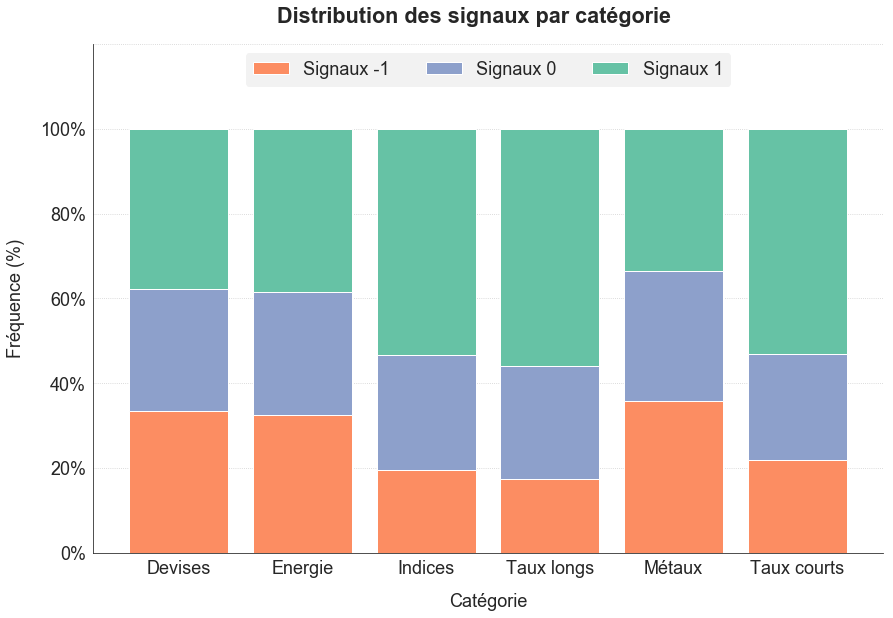

In [21]:
graph01 = sfg.MyGraph(title="Distribution des signaux par catégorie")
for snl in [1,-1,0]:
    graph01.add_barv(x_values=graph_data_01[graph_data_01.snl_signal==snl].category_name, 
                     y_height=graph_data_01[graph_data_01.snl_signal==snl].pourcentage_signaux,
                     y_bottom=graph_data_01[graph_data_01.snl_signal==snl].pourcentage_cumule - graph_data_01[graph_data_01.snl_signal==snl].pourcentage_signaux,
                     label="Signaux {}".format(snl))
graph01.set_axe('x', label="Catégorie", tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"])
graph01.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.2, tick_step=0.2, tick_labels=["0%","20%","40%","60%","80%","100%"," "])
graph01.set_legend(loc="upper center", ncol=3)
myhandles, mylabels = graph01.ax[0].get_legend_handles_labels()
graph01.ax[0].legend(loc="upper center", ncol=3,
                      handles=[myhandles[1], myhandles[2], myhandles[0]], labels=[mylabels[1],mylabels[2], mylabels[0]])
fig, ax = graph01.fig, graph01.ax
plt.savefig("M1_distrib_signaux_categorie.png")
plt.show()

Il y a des différences selon les catégories mais notre doctrine est de traiter toutes les catégories de la même façon.

In [22]:
graph_data_02 = signals[["trading_indicator","snl_signal","contract_id"]].groupby(["trading_indicator","snl_signal"]).count()
graph_data_02.columns = ["nombre_signaux"]
graph_data_02

nombre_signaux
trading_indicator snl_signal                
BRO               -1                15176301
                   0                10539553
                   1                28291196
FOT               -1                 8956868
                   0                24818237
                   1                20231945
MOM               -1                16407485
                   0                 8902757
                   1                28696808

In [23]:
graph_data_02.reset_index(inplace=True)
graph_data_02["total"] = graph_data_02.groupby("trading_indicator").nombre_signaux.transform(pd.Series.sum)
graph_data_02["pourcentage_signaux"] = graph_data_02.nombre_signaux / graph_data_02.total
graph_data_02["pourcentage_cumule"] = graph_data_02.groupby("trading_indicator").pourcentage_signaux.cumsum()
graph_data_02

,trading_indicator,snl_signal,nombre_signaux,total,pourcentage_signaux,pourcentage_cumule
0,BRO,-1,15176301,54007050,0.281006,0.281006
1,BRO,0,10539553,54007050,0.195151,0.476157
2,BRO,1,28291196,54007050,0.523843,1.000000
3,FOT,-1,8956868,54007050,0.165846,0.165846
4,FOT,0,24818237,54007050,0.459537,0.625383
5,FOT,1,20231945,54007050,0.374617,1.000000
6,MOM,-1,16407485,54007050,0.303803,0.303803
7,MOM,0,8902757,54007050,0.164844,0.468647
8,MOM,1,28696808,54007050,0.531353,1.000000


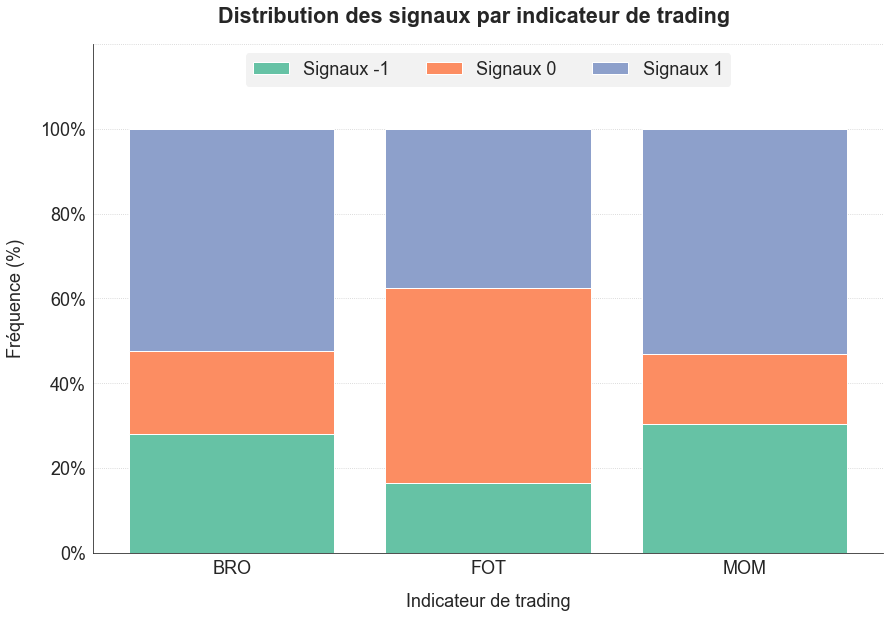

In [24]:
graph02 = sfg.MyGraph(title="Distribution des signaux par indicateur de trading")
for snl in np.arange(-1,2,1):
    graph02.add_barv(x_values=graph_data_02[graph_data_02.snl_signal==snl].trading_indicator, 
                     y_height=graph_data_02[graph_data_02.snl_signal==snl].pourcentage_signaux,
                     y_bottom=graph_data_02[graph_data_02.snl_signal==snl].pourcentage_cumule - graph_data_02[graph_data_02.snl_signal==snl].pourcentage_signaux,
                     label="Signaux {}".format(snl))
graph02.set_axe('x', label="Indicateur de trading")
graph02.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.2, tick_step=0.2, tick_labels=["0%","20%","40%","60%","80%","100%"," "])
graph02.set_legend(loc="upper center", ncol=3)
fig, ax = graph02.fig, graph02.ax
plt.savefig("M1_distrib_signaux_indicateur.png")
plt.show()

Il y a des différences notables selon les indicateurs de trading. L'indicateur FOT se déclenche plus difficilement que les eux autres : il présente beaucoup plus de signaux nuls que les indicateurs BRO et MOM.

In [25]:
graph_data_03 = signals[["param_time_period","snl_signal","contract_id"]].groupby(["param_time_period","snl_signal"]).count()
graph_data_03.columns = ["nombre_signaux"]
graph_data_03

nombre_signaux
param_time_period snl_signal                
LT1               -1                 6049191
                   0                 7985261
                   1                12969073
LT2               -1                 5939008
                   0                 8149682
                   1                12914835
LT3               -1                 5872330
                   0                 8187179
                   1                12944016
MT1               -1                 7965176
                   0                 6224713
                   1                12813636
MT2               -1                 7512718
                   0                 6744978
                   1                12745829
MT3               -1                 7202231
                   0                 6968734
                   1                12832560

In [26]:
ptp_sort = {'MT1': 1, 'MT2': 2, 'MT3': 3, 'LT1': 4, 'LT2': 5, 'LT3': 6}

In [27]:
graph_data_03.reset_index(inplace=True)
graph_data_03['ptp'] = pd.Categorical(graph_data_03['param_time_period'], ptp_sort)
graph_data_03.sort_values(by=['ptp','snl_signal'], inplace=True)
graph_data_03["total"] = graph_data_03.groupby("param_time_period").nombre_signaux.transform(pd.Series.sum)
graph_data_03["pourcentage_signaux"] = graph_data_03.nombre_signaux / graph_data_03.total
graph_data_03["pourcentage_cumule"] = graph_data_03.groupby("param_time_period").pourcentage_signaux.cumsum()
graph_data_03.head()

,param_time_period,snl_signal,nombre_signaux,ptp,total,pourcentage_signaux,pourcentage_cumule
9,MT1,-1,7965176,MT1,27003525,0.294968,0.294968
10,MT1,0,6224713,MT1,27003525,0.230515,0.525483
11,MT1,1,12813636,MT1,27003525,0.474517,1.000000
12,MT2,-1,7512718,MT2,27003525,0.278212,0.278212
13,MT2,0,6744978,MT2,27003525,0.249781,0.527994


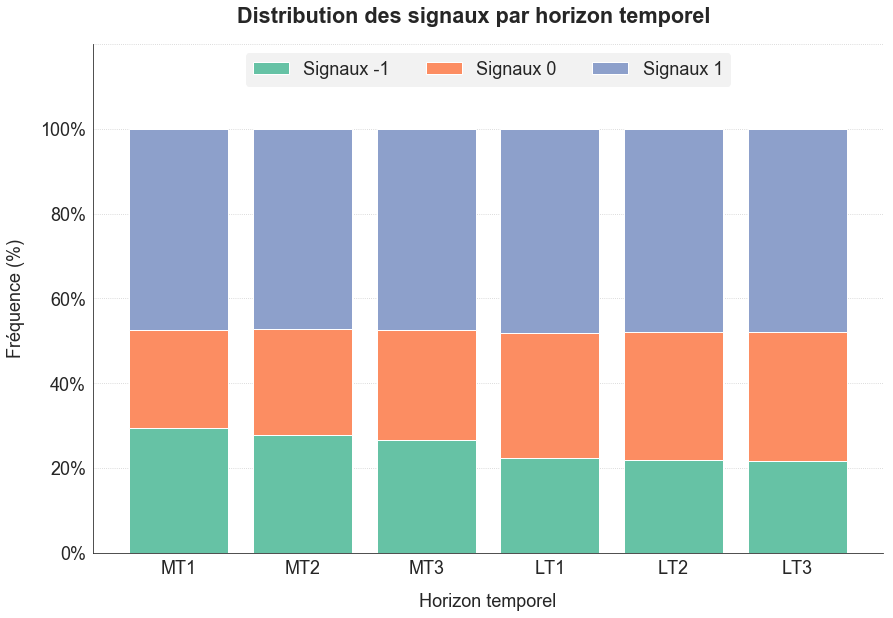

In [28]:
graph03 = sfg.MyGraph(title="Distribution des signaux par horizon temporel")
for snl in np.arange(-1,2,1):
    graph03.add_barv(x_values=graph_data_03[graph_data_03.snl_signal==snl].param_time_period, 
                     y_height=graph_data_03[graph_data_03.snl_signal==snl].pourcentage_signaux,
                     y_bottom=graph_data_03[graph_data_03.snl_signal==snl].pourcentage_cumule - graph_data_03[graph_data_03.snl_signal==snl].pourcentage_signaux,
                     label="Signaux {}".format(snl))
graph03.set_axe('x', label="Horizon temporel")
graph03.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.2, tick_step=0.2, tick_labels=["0%","20%","40%","60%","80%","100%"," "])
graph03.set_legend(loc="upper center", ncol=3)
fig, ax = graph03.fig, graph03.ax
plt.savefig("M1_distrib_signaux_horizon.png")
plt.show()

Il y a peu de différences dans la distribution des signaux selon les horizons temporels. Ce facteur ne semble pas très discriminant.

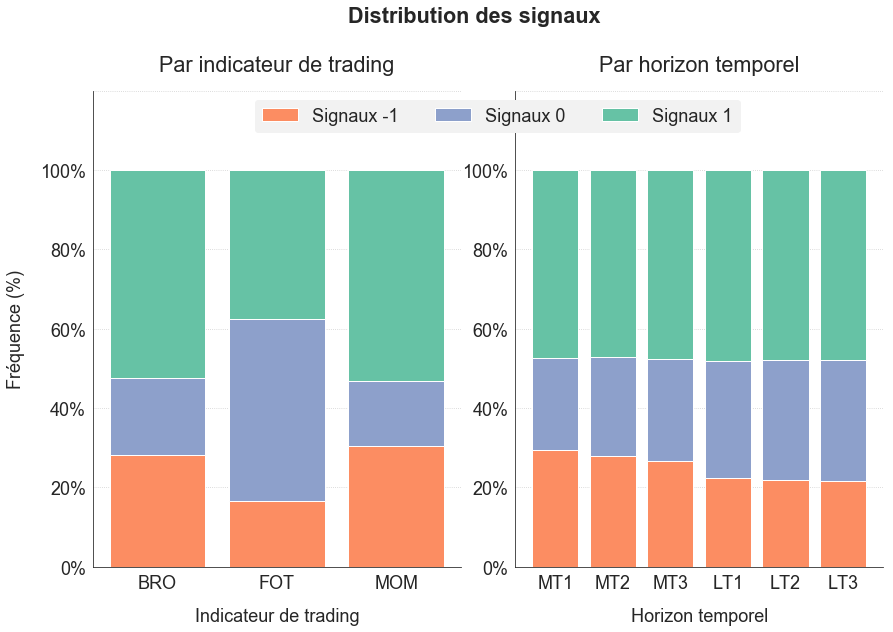

In [29]:
graph023 = sfg.MyGraph(title="Distribution des signaux", nbcol=2)
for snl in [1,-1,0]:
    graph023.add_barv(x_values=graph_data_02[graph_data_02.snl_signal==snl].trading_indicator, 
                     y_height=graph_data_02[graph_data_02.snl_signal==snl].pourcentage_signaux,
                     y_bottom=graph_data_02[graph_data_02.snl_signal==snl].pourcentage_cumule - graph_data_02[graph_data_02.snl_signal==snl].pourcentage_signaux,
                     label="Signaux {}".format(snl), subtitle="Par indicateur de trading", multi_index=1)
    graph023.add_barv(x_values=graph_data_03[graph_data_03.snl_signal==snl].param_time_period, 
                     y_height=graph_data_03[graph_data_03.snl_signal==snl].pourcentage_signaux,
                     y_bottom=graph_data_03[graph_data_03.snl_signal==snl].pourcentage_cumule - graph_data_03[graph_data_03.snl_signal==snl].pourcentage_signaux,
                     label="Signaux {}".format(snl), subtitle="Par horizon temporel", multi_index=2)
graph023.set_axe('x', label="Indicateur de trading", multi_index=1)
graph023.set_axe('x', label="Horizon temporel", multi_index=2)
graph023.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.2, tick_step=0.2, tick_labels=["0%","20%","40%","60%","80%","100%"," "], multi_index=1)
graph023.set_axe('y', tick_min=0, tick_max=1.2, tick_step=0.2, tick_labels=["0%","20%","40%","60%","80%","100%"," "], multi_index=2)
graph023.set_legend(loc="upper center", ncol=3, bbox_to_anchor=(-0.05,1), multi_index=2)
myhandles, mylabels = graph023.ax[1].get_legend_handles_labels()
graph023.ax[1].legend(loc="upper center", ncol=3, bbox_to_anchor=(-0.05,1), \
                      handles=[myhandles[1], myhandles[2], myhandles[0]], labels=[mylabels[1],mylabels[2], mylabels[0]])
fig, ax = graph023.fig, graph023.ax
plt.savefig("M1_distrib_signaux_indicateur_horizon.png")
plt.show()

In [30]:
graph_data_04 = signals[["category_name","snl_signal","contract_id"]].groupby(["contract_id","snl_signal"]).count()
graph_data_04.columns = ["nombre_signaux"]
graph_data_04.reset_index(inplace=True)
graph_data_04["total"] = graph_data_04.groupby("contract_id").nombre_signaux.transform(pd.Series.sum)
graph_data_04["pourcentage_signaux"] = graph_data_04.nombre_signaux / graph_data_04.total
graph_data_04["pourcentage_cumule"] = graph_data_04.groupby("contract_id").pourcentage_signaux.cumsum()
graph_data_04 = graph_data_04.merge(contracts[["name"]], how='left', left_on="contract_id", right_index=True)
graph_data_04 = graph_data_04.merge(categorie_contrat, how='left', on="contract_id")
graph_data_04.sort_values(by=["category_name","contract_id","snl_signal"], inplace=True)
graph_data_04.head()

,contract_id,snl_signal,nombre_signaux,total,pourcentage_signaux,pourcentage_cumule,name,category_name
0,1,-1,943032,3454650,0.272975,0.272975,AUD,Currencies
1,1,0,1012975,3454650,0.293221,0.566195,AUD,Currencies
2,1,1,1498643,3454650,0.433805,1.000000,AUD,Currencies
3,2,-1,1237249,3474450,0.356099,0.356099,CAD,Currencies
4,2,0,1030763,3474450,0.296669,0.652769,CAD,Currencies


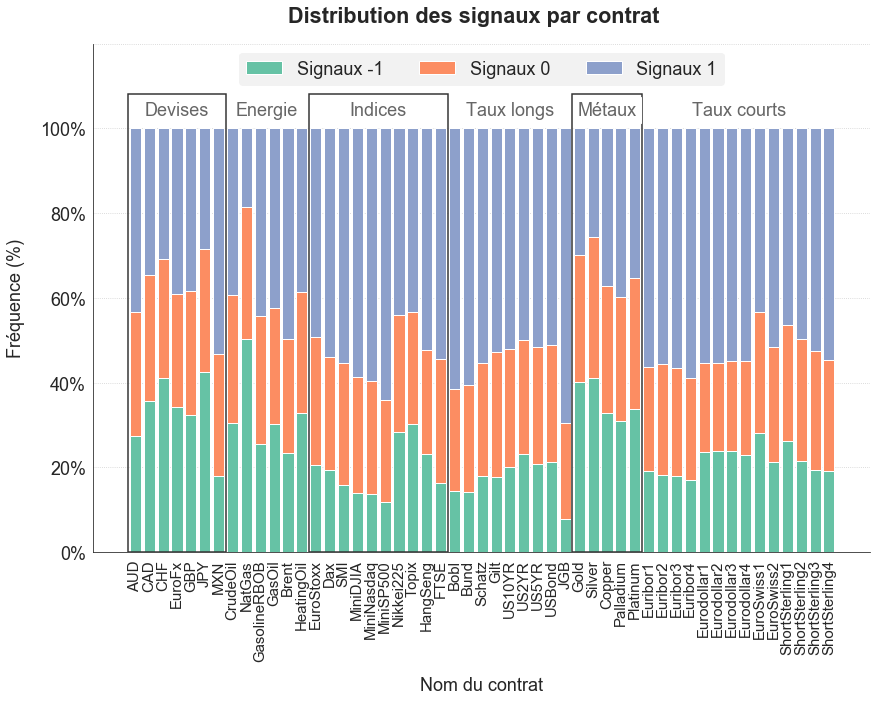

In [31]:
graph04 = sfg.MyGraph(title="Distribution des signaux par contrat")
for snl in np.arange(-1,2,1):
    graph04.add_barv(x_values=graph_data_04[graph_data_04.snl_signal==snl].name, 
                     y_height=graph_data_04[graph_data_04.snl_signal==snl].pourcentage_signaux,
                     y_bottom=graph_data_04[graph_data_04.snl_signal==snl].pourcentage_cumule - graph_data_04[graph_data_04.snl_signal==snl].pourcentage_signaux,
                     label="Signaux {}".format(snl))
graph04.add_rectangle(coord_min=-0.5, coord_max=6.5, rect_max=0.90, color=(0.2,0.2,0.2))
graph04.add_rectangle(coord_min=12.5, coord_max=22.5, rect_max=0.90, color=(0.2,0.2,0.2))
graph04.add_rectangle(coord_min=31.5, coord_max=36.5, rect_max=0.90, color=(0.2,0.2,0.2))
graph04.add_text(x_coord=3, y_coord=1.065, text="Devises", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph04.add_text(x_coord=9.5, y_coord=1.065, text="Energie", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph04.add_text(x_coord=17.5, y_coord=1.065, text="Indices", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph04.add_text(x_coord=27, y_coord=1.065, text="Taux longs", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph04.add_text(x_coord=34, y_coord=1.065, text="Métaux", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph04.add_text(x_coord=43.5, y_coord=1.065, text="Taux courts", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph04.set_axe('x', label="Nom du contrat", rotation=90)
graph04.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.2, tick_step=0.2, tick_labels=["0%","20%","40%","60%","80%","100%"," "])
graph04.set_legend(loc="upper center", ncol=3)
fig, ax = graph04.fig, graph04.ax
ax[0].tick_params(axis='x', labelsize=15)
plt.savefig("M1_distrib_signaux_contrat.png")
plt.show()

Les contrats au sein d'une même catégorie présentent globalement une distribution similaire.

<a id='1_3'></a>

### 1.3. Agrégation des signaux

In [32]:
agreg_contrat = signals[["category_name","contract_id","dateref","snl_signal"]].groupby(["category_name","contract_id","dateref"]).sum()
agreg_contrat.columns = ["somme_signaux"]
agreg_contrat.head()

somme_signaux
category_name contract_id dateref                  
Currencies    1           1989-11-01              0
                          1989-11-02              0
                          1989-11-03              0
                          1989-11-06              0
                          1989-11-07              0

In [33]:
print("Somme min = {}".format(agreg_contrat.somme_signaux.min()))
print("Somme max = {}".format(agreg_contrat.somme_signaux.max()))
print("Somme moyenne = {}".format(agreg_contrat.somme_signaux.mean()))
print("Somme mediane = {}".format(agreg_contrat.somme_signaux.median()))

Somme min = -448
Somme max = 450
Somme moyenne = 101.8736303871439
Somme mediane = 134.0


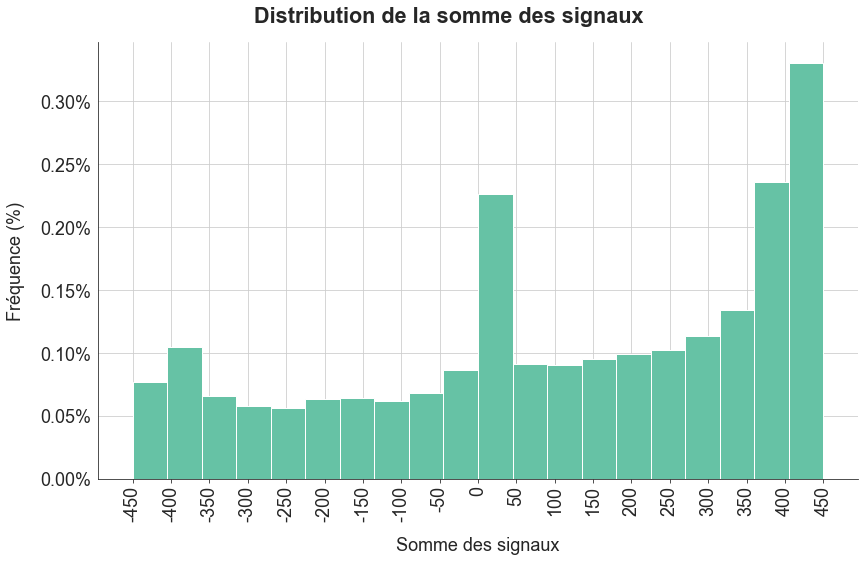

In [34]:
graph05 = sfg.MyGraph(title="Distribution de la somme des signaux", figsize=(12,7))
graph05.add_histogramme(agreg_contrat.somme_signaux, range=(-450,450))
graph05.set_axe('x', label="Somme des signaux", tick_min=-450, tick_max=450, tick_step=50, tick_labels_format=':.0f', rotation=90, ha='center', tick_dash=True)
graph05.set_axe('y', label="Fréquence (%)", tick_labels_format=':.2%')
fig, ax = graph05.fig, graph05.ax
plt.savefig("M1_distrib_sommes.png")
plt.show()

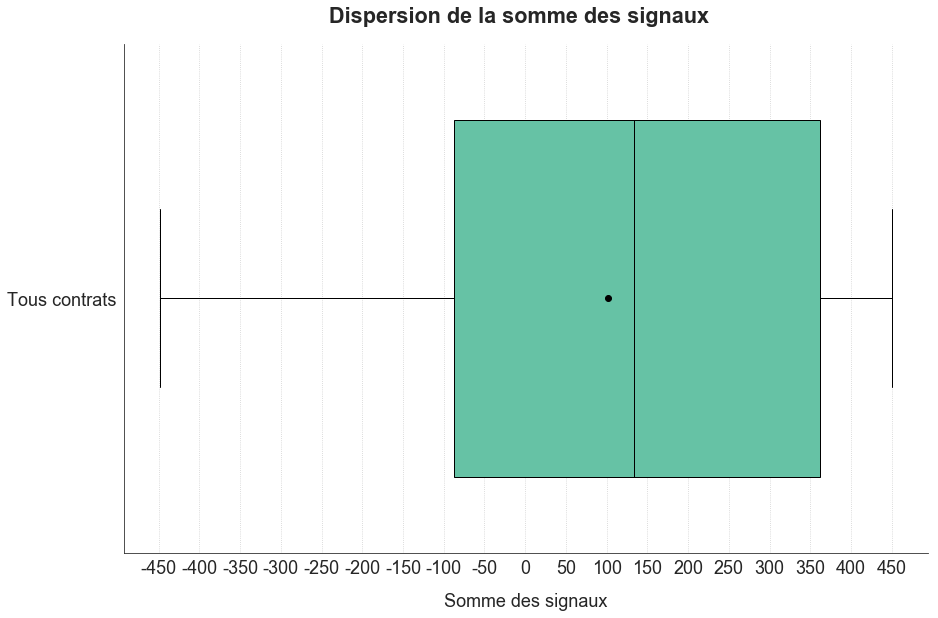

In [47]:
graph06 = sfg.MyGraph(title="Dispersion de la somme des signaux")
graph06.add_boxplot(agreg_contrat.somme_signaux, means=True, vertical=False)
graph06.set_axe('x', label="Somme des signaux", tick_min=-450, tick_max=450, tick_step=50, tick_labels_format=':.0f')
graph06.set_axe('y', tick_labels=["Tous contrats"])
fig, ax = graph06.fig, graph06.ax
#plt.savefig("M1_dispersion_sommes.png")
plt.show()

In [48]:
interdata = agreg_contrat.reset_index().groupby(["category_name","contract_id","somme_signaux"]).count().reset_index()
interdata.columns = ["category_name","contract_id","somme_signaux","nombre"]
interdata["bins"] = pd.cut(interdata.somme_signaux, [-450,-300,-150,0,150,300,450], include_lowest=True)
interdata.head()

,category_name,contract_id,somme_signaux,nombre,bins
0,Currencies,1,-403,2,"(-450.001, -300.0]"
1,Currencies,1,-402,5,"(-450.001, -300.0]"
2,Currencies,1,-401,19,"(-450.001, -300.0]"
3,Currencies,1,-400,10,"(-450.001, -300.0]"
4,Currencies,1,-399,13,"(-450.001, -300.0]"


In [49]:
graph_data = interdata.groupby(["category_name","contract_id","bins"]).nombre.sum().reset_index().sort_values(by=["category_name","contract_id","bins"])
graph_data["total"] = graph_data.groupby("contract_id").nombre.transform(pd.Series.sum)
graph_data["pourcentage_signaux"] = graph_data.nombre / graph_data.total
graph_data["pourcentage_cumule"] = graph_data.groupby("contract_id").pourcentage_signaux.cumsum()
graph_data = graph_data.merge(contracts[["name"]], how='left', left_on="contract_id", right_index=True)
graph_data.sort_values(by=["category_name","contract_id","bins"], inplace=True)
graph_data.head()

,category_name,contract_id,bins,nombre,total,pourcentage_signaux,pourcentage_cumule,name
0,Currencies,1,"(-450.001, -300.0]",988,7677,0.128696,0.128696,AUD
1,Currencies,1,"(-300.0, -150.0]",832,7677,0.108376,0.237072,AUD
2,Currencies,1,"(-150.0, 0.0]",1531,7677,0.199427,0.436499,AUD
3,Currencies,1,"(0.0, 150.0]",994,7677,0.129478,0.565976,AUD
4,Currencies,1,"(150.0, 300.0]",1162,7677,0.151361,0.717338,AUD


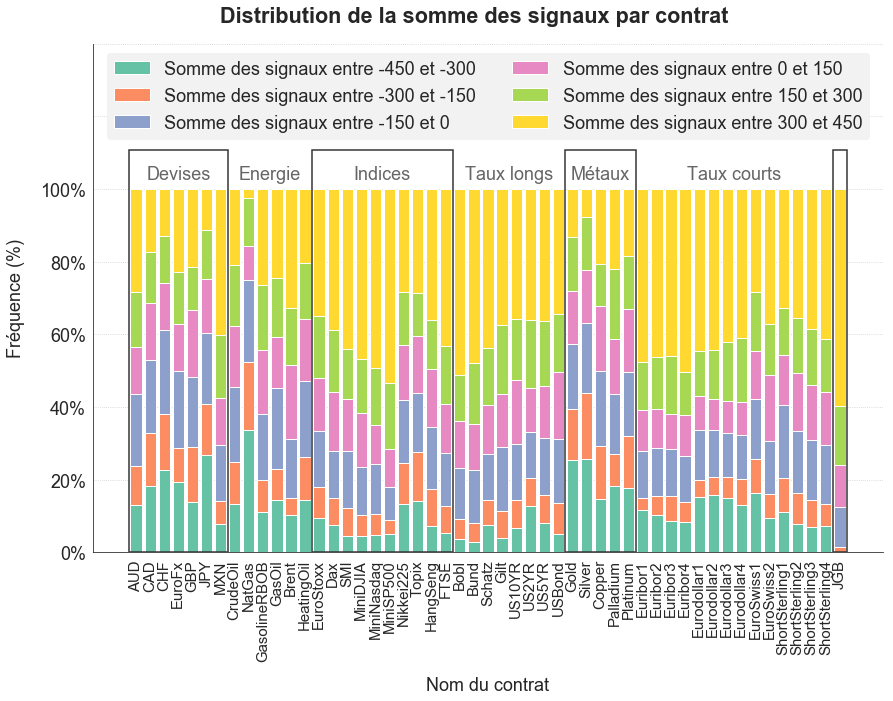

In [50]:
graph07 = sfg.MyGraph(title="Distribution de la somme des signaux par contrat")
for mybin in graph_data.bins.unique():
    graph07.add_barv(x_values=graph_data[graph_data.bins==mybin].name, 
                     y_height=graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     y_bottom=graph_data[graph_data.bins==mybin].pourcentage_cumule - graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     label="Somme des signaux entre {:.0f} et {:.0f}".format(mybin.left, mybin.right))
graph07.add_rectangle(coord_min=-0.5, coord_max=6.5, rect_max=0.79, color=(0.2,0.2,0.2))
graph07.add_rectangle(coord_min=12.5, coord_max=22.5, rect_max=0.79, color=(0.2,0.2,0.2))
graph07.add_rectangle(coord_min=30.5, coord_max=35.5, rect_max=0.79, color=(0.2,0.2,0.2))
graph07.add_rectangle(coord_min=49.5, coord_max=50.5, rect_max=0.79, color=(0.2,0.2,0.2))
graph07.add_text(x_coord=3, y_coord=1.065, text="Devises", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph07.add_text(x_coord=9.5, y_coord=1.065, text="Energie", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph07.add_text(x_coord=17.5, y_coord=1.065, text="Indices", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph07.add_text(x_coord=26.5, y_coord=1.065, text="Taux longs", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph07.add_text(x_coord=33, y_coord=1.065, text="Métaux", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph07.add_text(x_coord=42.5, y_coord=1.065, text="Taux courts", color=(0.4,0.4,0.4), backgroundcolor=(1,1,1))
graph07.set_axe('x', label="Nom du contrat", rotation=90)
graph07.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.4, tick_labels=["0%","20%","40%","60%","80%","100%"," "," "])
graph07.set_legend(loc="upper center", ncol=2)
fig, ax = graph07.fig, graph07.ax
ax[0].tick_params(axis='x', labelsize=15)
plt.savefig("M1_distrib_somme_contrat.png")
plt.show()

Homogénéité au sein de chaque catégorie.  
On note que le JGB n'a aucun somme de signaux inférieure à -300 et très peu inférieure à -150. Cela traduit une sur-représentation des tendances haussières du marché des taux longs japonais.  
A l'inverse, le marché le plus souvent en période baissière sur la période est le gas naturel.

In [51]:
agreg_contrat_indicateur = signals[["category_name","contract_id","dateref","trading_indicator","snl_signal"]].groupby(["trading_indicator","category_name","contract_id","dateref"]).sum()
agreg_contrat_indicateur.columns = ["somme_signaux"]
agreg_contrat_indicateur.reset_index(inplace=True)
agreg_contrat_indicateur.head()

,trading_indicator,category_name,contract_id,dateref,somme_signaux
0,BRO,Currencies,1,1989-11-01,0
1,BRO,Currencies,1,1989-11-02,0
2,BRO,Currencies,1,1989-11-03,0
3,BRO,Currencies,1,1989-11-06,0
4,BRO,Currencies,1,1989-11-07,0


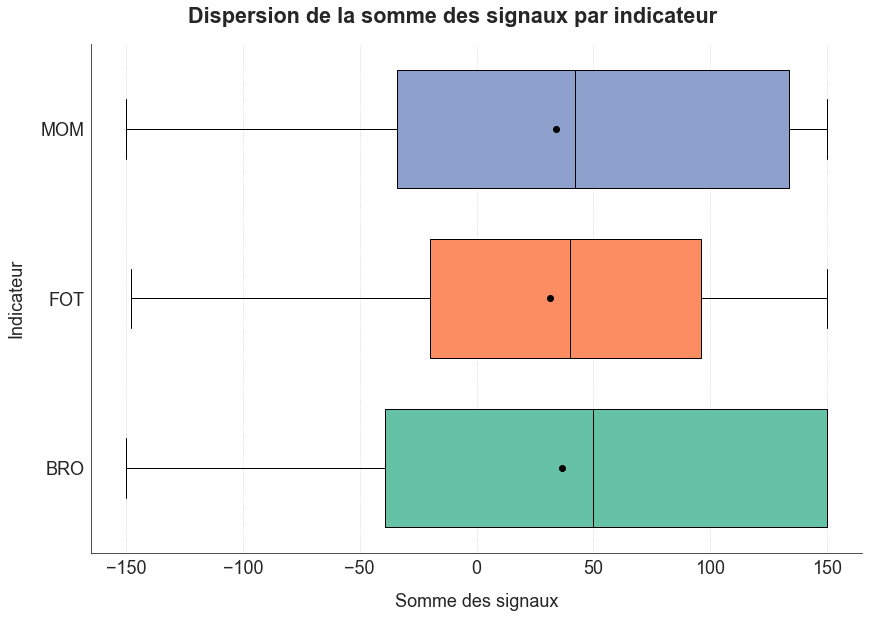

In [52]:
valeurs = [agreg_contrat_indicateur[agreg_contrat_indicateur.trading_indicator==trad].somme_signaux.values for trad in agreg_contrat_indicateur.trading_indicator.unique()]
graph08 = sfg.MyGraph(title="Dispersion de la somme des signaux par indicateur")
graph08.add_boxplot(values=valeurs, cat_labels=agreg_contrat_indicateur.trading_indicator.unique(), means=True, vertical=False)
graph08.set_axe('x', label="Somme des signaux")
graph08.set_axe('y', label="Indicateur")
fig, ax = graph08.fig, graph08.ax
#plt.savefig("M1_dispersion_somme_indicateur.png")
plt.show()

In [53]:
interdata = agreg_contrat_indicateur.groupby(["trading_indicator","somme_signaux"]).contract_id.count().reset_index()
interdata.columns = ["trading_indicator","somme_signaux","nombre"]
interdata["bins"] = pd.cut(interdata.somme_signaux, [-150,-100,-50,0,50,100,150], include_lowest=True)
interdata.head()

,trading_indicator,somme_signaux,nombre,bins
0,BRO,-150,31532,"(-150.001, -100.0]"
1,BRO,-149,1772,"(-150.001, -100.0]"
2,BRO,-148,900,"(-150.001, -100.0]"
3,BRO,-147,1196,"(-150.001, -100.0]"
4,BRO,-146,947,"(-150.001, -100.0]"


In [54]:
graph_data = interdata.groupby(["trading_indicator","bins"]).nombre.sum().reset_index().sort_values(by=["trading_indicator","bins"])
graph_data["total"] = graph_data.groupby("trading_indicator").nombre.transform(pd.Series.sum)
graph_data["pourcentage_signaux"] = graph_data.nombre / graph_data.total
graph_data["pourcentage_cumule"] = graph_data.groupby("trading_indicator").pourcentage_signaux.cumsum()
graph_data.head()

,trading_indicator,bins,nombre,total,pourcentage_signaux,pourcentage_cumule
0,BRO,"(-150.001, -100.0]",57020,360047,0.158368,0.158368
1,BRO,"(-100.0, -50.0]",28105,360047,0.078059,0.236427
2,BRO,"(-50.0, 0.0]",58639,360047,0.162865,0.399292
3,BRO,"(0.0, 50.0]",37644,360047,0.104553,0.503845
4,BRO,"(50.0, 100.0]",47582,360047,0.132155,0.636000


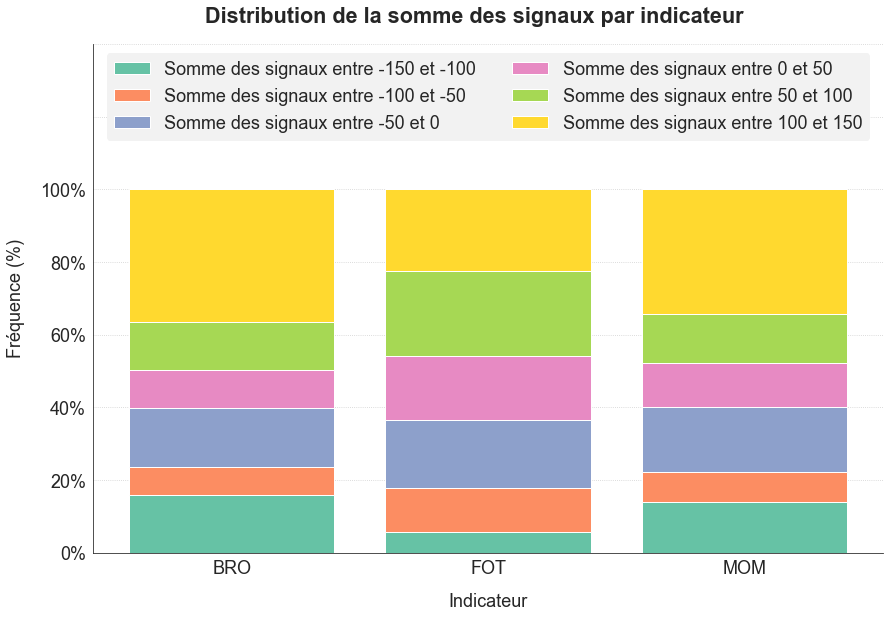

In [55]:
graph09 = sfg.MyGraph(title="Distribution de la somme des signaux par indicateur")
for mybin in graph_data.bins.unique():
    graph09.add_barv(x_values=graph_data[graph_data.bins==mybin].trading_indicator, 
                     y_height=graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     y_bottom=graph_data[graph_data.bins==mybin].pourcentage_cumule - graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     label="Somme des signaux entre {:.0f} et {:.0f}".format(mybin.left, mybin.right))
graph09.set_axe('x', label="Indicateur")
graph09.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.4, tick_labels=["0%","20%","40%","60%","80%","100%"," "," "])
graph09.set_legend(loc="upper center", ncol=2)
fig, ax = graph09.fig, graph09.ax
plt.savefig("M1_distrib_somme_indicateur.png")
plt.show()

La plus grande sélectivité de l'indicateur FOT est confirmée par ce graphique. Les sommes extrêmes sont moins fréquentes pour cet indicateur. Cela traduit soit que cet indicateur est plus difficile à déclencher à horizon temporel égal, soit qu'il s'annule plus rapidement.

In [56]:
agreg_contrat_horizon = signals[["category_name","contract_id","dateref","param_time_period","snl_signal"]].groupby(["param_time_period","category_name","contract_id","dateref"]).sum()
agreg_contrat_horizon.columns = ["somme_signaux"]
agreg_contrat_horizon.reset_index(inplace=True)
agreg_contrat_horizon.head()

,param_time_period,category_name,contract_id,dateref,somme_signaux
0,LT1,Currencies,1,1989-11-01,0
1,LT1,Currencies,1,1989-11-02,0
2,LT1,Currencies,1,1989-11-03,0
3,LT1,Currencies,1,1989-11-06,0
4,LT1,Currencies,1,1989-11-07,0


In [57]:
#np.sort(pd.Categorical(agreg_contrat_horizon.param_time_period.unique(), ptp_sort))
pd.Categorical(agreg_contrat_horizon.param_time_period.unique(), ptp_sort).categories.values

array(['MT1', 'MT2', 'MT3', 'LT1', 'LT2', 'LT3'], dtype=object)

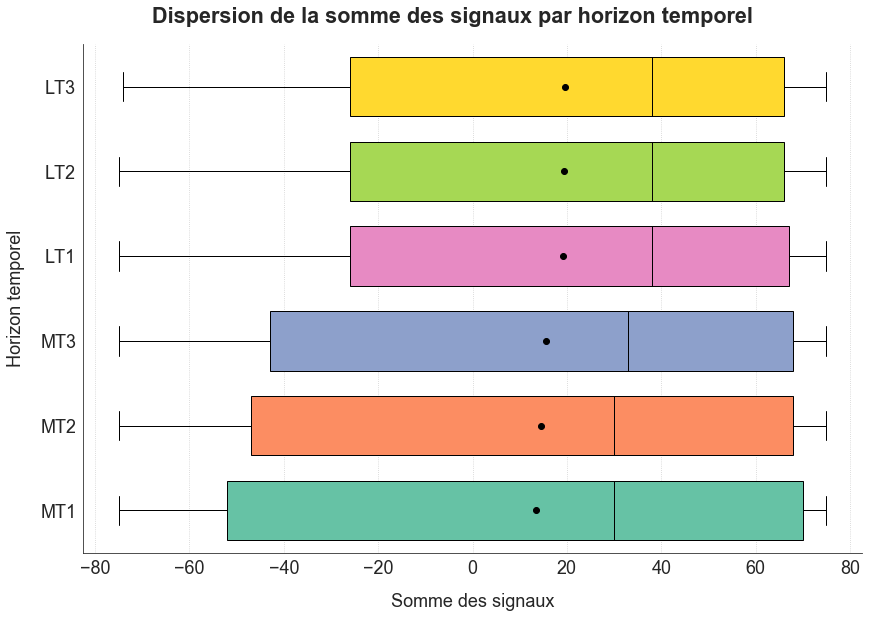

In [58]:
cat_labels = pd.Categorical(agreg_contrat_horizon.param_time_period.unique(), ptp_sort).categories.values
valeurs = [agreg_contrat_horizon[agreg_contrat_horizon.param_time_period==ptp].somme_signaux.values for ptp in cat_labels]
graph10 = sfg.MyGraph(title="Dispersion de la somme des signaux par horizon temporel")
graph10.add_boxplot(values=valeurs, cat_labels=cat_labels, means=True, vertical=False)
graph10.set_axe('x', label="Somme des signaux")
graph10.set_axe('y', label="Horizon temporel")
fig, ax = graph10.fig, graph10.ax
#plt.savefig("M1_dispersion_somme_horizon.png")
plt.show()

In [59]:
interdata = agreg_contrat_horizon.groupby(["param_time_period","somme_signaux"]).contract_id.count().reset_index()
interdata.columns = ["param_time_period","somme_signaux","nombre"]
interdata["bins"] = pd.cut(interdata.somme_signaux, [-75,-50,-25,0,25,50,75], include_lowest=True)
interdata.head()

,param_time_period,somme_signaux,nombre,bins
0,LT1,-75,524,"(-75.001, -50.0]"
1,LT1,-74,896,"(-75.001, -50.0]"
2,LT1,-73,858,"(-75.001, -50.0]"
3,LT1,-72,3361,"(-75.001, -50.0]"
4,LT1,-71,3172,"(-75.001, -50.0]"


In [60]:
graph_data = interdata.groupby(["param_time_period","bins"]).nombre.sum().reset_index()
graph_data["total"] = graph_data.groupby("param_time_period").nombre.transform(pd.Series.sum)
graph_data["pourcentage_signaux"] = graph_data.nombre / graph_data.total
graph_data["pourcentage_cumule"] = graph_data.groupby("param_time_period").pourcentage_signaux.cumsum()
graph_data['ptp'] = pd.Categorical(graph_data['param_time_period'], ptp_sort)
graph_data.sort_values(by=['ptp','bins'], inplace=True)
graph_data.head()

,param_time_period,bins,nombre,total,pourcentage_signaux,pourcentage_cumule,ptp
18,MT1,"(-75.001, -50.0]",93698,360047,0.260238,0.260238,MT1
19,MT1,"(-50.0, -25.0]",23751,360047,0.065966,0.326205,MT1
20,MT1,"(-25.0, 0.0]",40315,360047,0.111971,0.438176,MT1
21,MT1,"(0.0, 25.0]",18625,360047,0.051729,0.489905,MT1
22,MT1,"(25.0, 50.0]",23129,360047,0.064239,0.554144,MT1


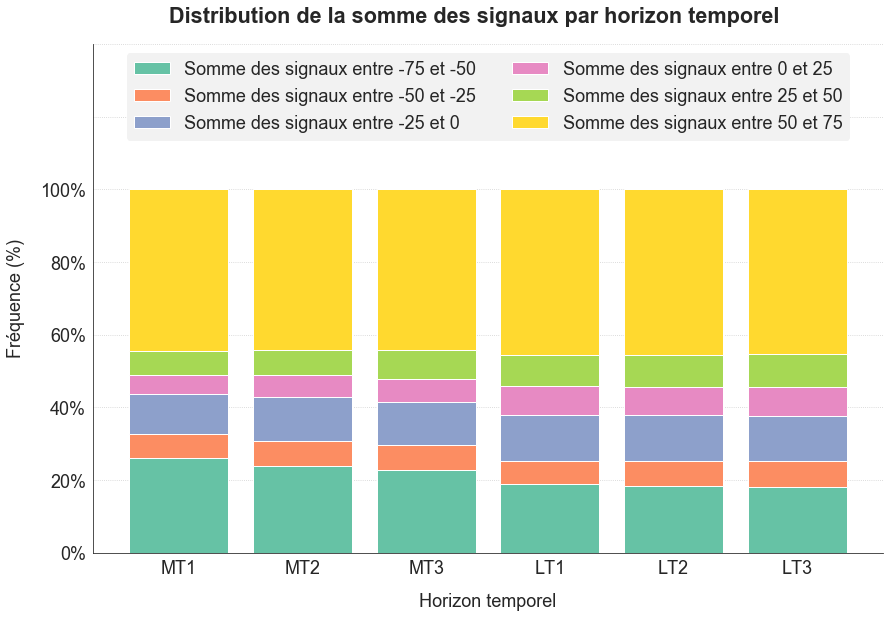

In [61]:
graph11 = sfg.MyGraph(title="Distribution de la somme des signaux par horizon temporel")
for mybin in graph_data.bins.unique():
    graph11.add_barv(x_values=graph_data[graph_data.bins==mybin].param_time_period, 
                     y_height=graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     y_bottom=graph_data[graph_data.bins==mybin].pourcentage_cumule - graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     label="Somme des signaux entre {:.0f} et {:.0f}".format(mybin.left, mybin.right))
graph11.set_axe('x', label="Horizon temporel")
graph11.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.4, tick_labels=["0%","20%","40%","60%","80%","100%"," "," "])
graph11.set_legend(loc="upper center", ncol=2)
fig, ax = graph11.fig, graph11.ax
plt.savefig("M1_distrib_somme_horizon.png")
plt.show()

La distribution de la somme des signaux est à peu près identique quelque soit l'horizon temporel.  
On note juste que moins l'horizon temporel est long, plus les positions fortement négatives sont fréquentes. Cela s'explique par la structure des corrections baissières, à savoir violentes et courtes. Elles sont plus facilement captées par les systèmes à plus court terme alors que les systèmes à plus long terme ne se retournent pas sur ces corrections baissières temporaires.

In [62]:
agreg_categorie = agreg_contrat.reset_index().groupby(["category_name","dateref"]).somme_signaux.mean().reset_index()
agreg_categorie.columns = ["category_name","dateref","moyenne_somme_signaux"]
agreg_categorie.head()

,category_name,dateref,moyenne_somme_signaux
0,Currencies,1989-06-01,0.0
1,Currencies,1989-06-02,0.0
2,Currencies,1989-06-06,0.0
3,Currencies,1989-06-07,0.0
4,Currencies,1989-06-08,0.0


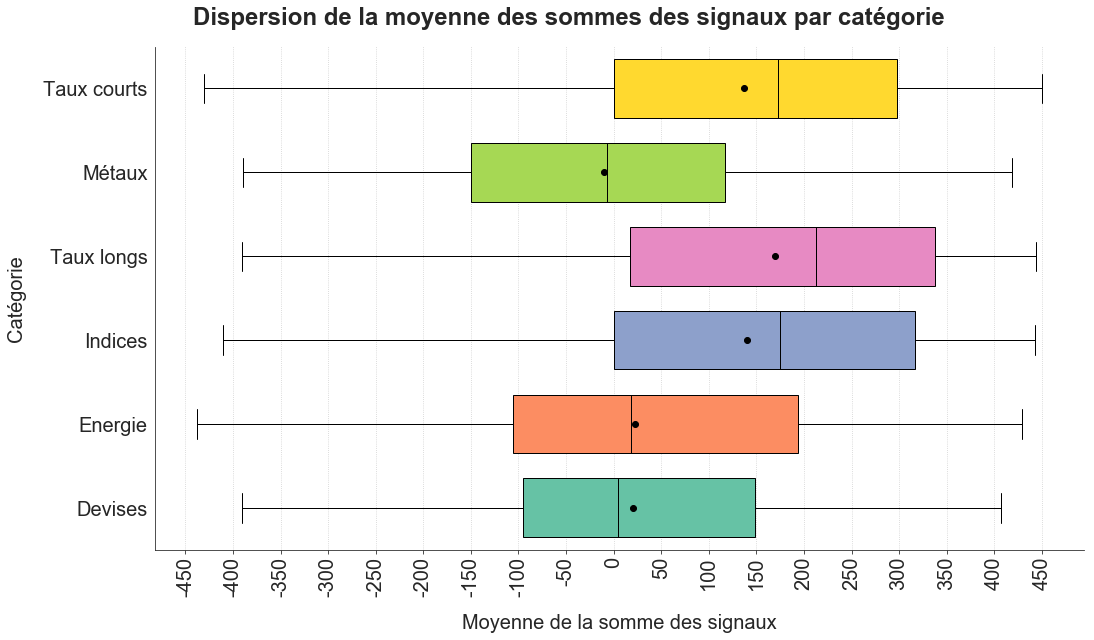

In [63]:
valeurs = [agreg_categorie[agreg_categorie.category_name==cat].moyenne_somme_signaux for cat in agreg_categorie.category_name.unique()]
graph12 = sfg.MyGraph(title="Dispersion de la moyenne des sommes des signaux par catégorie")
graph12.add_boxplot(values=valeurs, cat_labels=agreg_categorie.category_name.unique(), means=True, vertical=False)
graph12.set_axe('x', label="Moyenne de la somme des signaux", tick_min=-450, tick_max=450, tick_step=50, tick_labels_format=':.0f', tick_dash=True, rotation=90)
graph12.set_axe('y', label="Catégorie", tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"])
fig, ax = graph12.fig, graph12.ax
plt.savefig("M1_dispersion_moyenne_signaux_categorie.png")
plt.show()

Ce graphique confirme bien la tendance haussière des marchés de taux, longs comme courts, et des indices boursiers sur la période étudiée.  
La configuration des autres marchés est plus équilibrée sur la période, avec un corps de boite à moustache plus centré autour de zéro ainsiq que des moyennes et des médianes assez proches de zéro.

In [83]:
interdata = agreg_categorie.groupby(["category_name","moyenne_somme_signaux"]).dateref.count().reset_index()
interdata.columns = ["category_name","moyenne_somme_signaux","nombre"]
interdata["bins"] = pd.cut(interdata.moyenne_somme_signaux, [-450,-300,-150,0,150,300,450], include_lowest=True)
interdata.head()

,category_name,moyenne_somme_signaux,nombre,bins
0,Currencies,-390.500000,1,"(-450.001, -300.0]"
1,Currencies,-373.500000,1,"(-450.001, -300.0]"
2,Currencies,-372.000000,1,"(-450.001, -300.0]"
3,Currencies,-351.857143,1,"(-450.001, -300.0]"
4,Currencies,-351.285714,1,"(-450.001, -300.0]"


In [84]:
graph_data = interdata.groupby(["category_name","bins"]).nombre.sum().reset_index()
graph_data["total"] = graph_data.groupby("category_name").nombre.transform(pd.Series.sum)
graph_data["pourcentage_signaux"] = graph_data.nombre / graph_data.total
graph_data["pourcentage_cumule"] = graph_data.groupby("category_name").pourcentage_signaux.cumsum()
graph_data.head()

,category_name,bins,nombre,total,pourcentage_signaux,pourcentage_cumule
0,Currencies,"(-450.001, -300.0]",201,7787,0.025812,0.025812
1,Currencies,"(-300.0, -150.0]",1083,7787,0.139078,0.164890
2,Currencies,"(-150.0, 0.0]",2513,7787,0.322717,0.487608
3,Currencies,"(0.0, 150.0]",2061,7787,0.264672,0.752279
4,Currencies,"(150.0, 300.0]",1642,7787,0.210864,0.963144


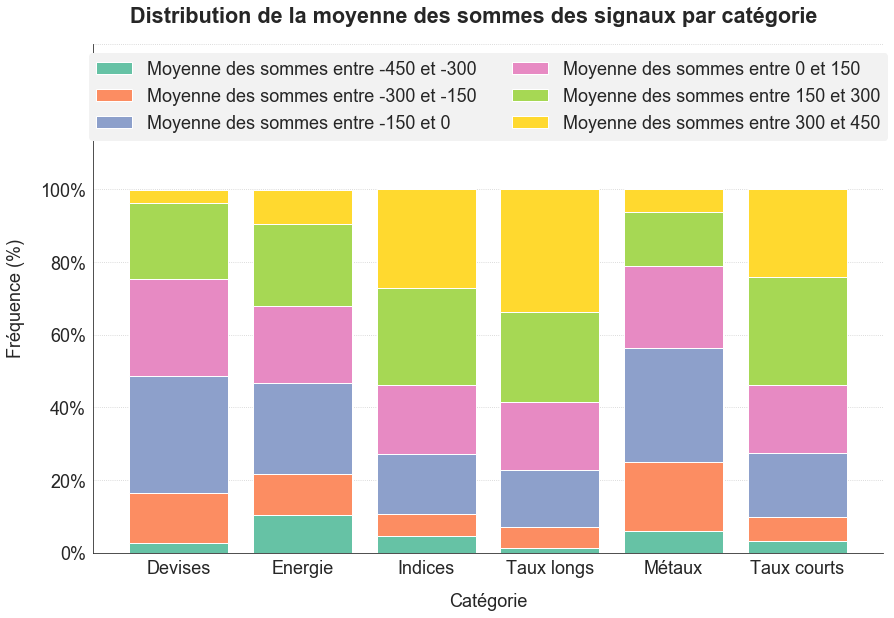

In [85]:
graph13 = sfg.MyGraph(title="Distribution de la moyenne des sommes des signaux par catégorie")
for mybin in graph_data.bins.unique():
    graph13.add_barv(x_values=graph_data[graph_data.bins==mybin].category_name, 
                     y_height=graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     y_bottom=graph_data[graph_data.bins==mybin].pourcentage_cumule - graph_data[graph_data.bins==mybin].pourcentage_signaux,
                     label="Moyenne des sommes entre {:.0f} et {:.0f}".format(mybin.left, mybin.right))
graph13.set_axe('x', label="Catégorie", tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"])
graph13.set_axe('y', label="Fréquence (%)", tick_min=0, tick_max=1.4, tick_labels=["0%","20%","40%","60%","80%","100%"," "," "])
graph13.set_legend(loc="upper center", ncol=2)
fig, ax = graph13.fig, graph13.ax
#plt.savefig("M1_distrib_moyenne_signaux_categorie.png")
plt.show()

In [86]:
agreg_categorie_indicateur = agreg_contrat_indicateur.reset_index().groupby(["category_name","trading_indicator","dateref"]).somme_signaux.mean().reset_index()
agreg_categorie_indicateur.columns = ["category_name","trading_indicator","dateref","moyenne_somme_signaux"]
agreg_categorie_indicateur.head()

,category_name,trading_indicator,dateref,moyenne_somme_signaux
0,Currencies,BRO,1989-06-01,0.0
1,Currencies,BRO,1989-06-02,0.0
2,Currencies,BRO,1989-06-06,0.0
3,Currencies,BRO,1989-06-07,0.0
4,Currencies,BRO,1989-06-08,0.0


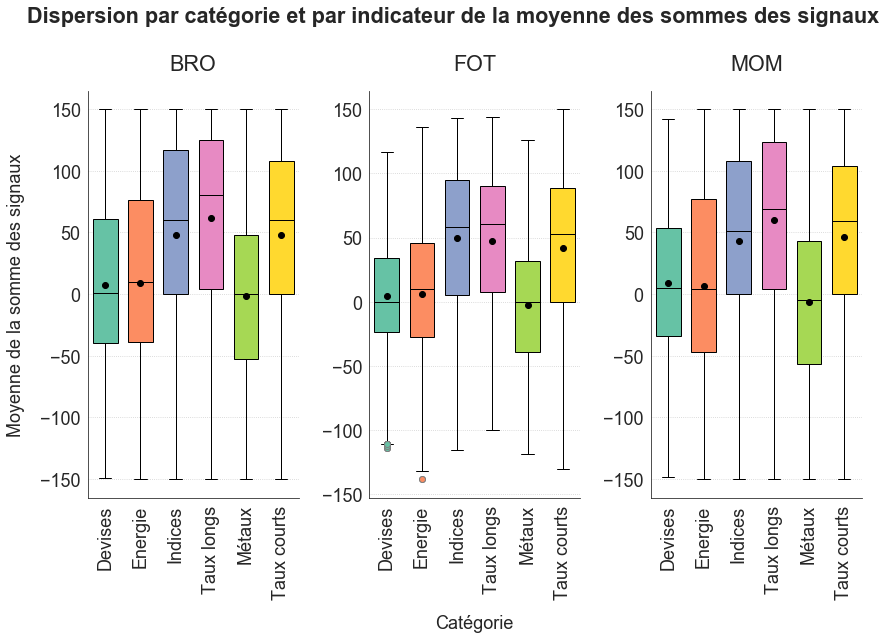

In [87]:
graph14 = sfg.MyGraph(title="Dispersion par catégorie et par indicateur de la moyenne des sommes des signaux", nblin=1, nbcol=3)
cpt = 1
for indicateur in agreg_categorie_indicateur.trading_indicator.unique():
    valeurs = [agreg_categorie_indicateur[(agreg_categorie_indicateur.category_name==cat) & (agreg_categorie_indicateur.trading_indicator==indicateur)].moyenne_somme_signaux for cat in agreg_categorie_indicateur.category_name.unique()]
    graph14.add_boxplot(values=valeurs, cat_labels=agreg_categorie_indicateur.category_name.unique(), means=True, vertical=True, color_base_index=0, subtitle=indicateur, multi_index=cpt)
    graph14.set_axe('x', rotation=90, ha='center', multi_index=cpt)
    cpt += 1
graph14.set_axe('y', label="Moyenne de la somme des signaux")
graph14.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=1)
graph14.set_axe('x', label="Catégorie", tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=2)
graph14.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=3)
fig, ax = graph14.fig, graph14.ax
#plt.savefig("M1_dispersion_moyenne_categorie_indicateur.png")
plt.show()

In [88]:
interdata = agreg_categorie_indicateur.groupby(["trading_indicator","category_name","moyenne_somme_signaux"]).dateref.count().reset_index()
interdata.columns = ["trading_indicator","category_name","moyenne_somme_signaux","nombre"]
interdata["bins"] = pd.cut(interdata.moyenne_somme_signaux, [-150,-100,-50,0,50,100,150], include_lowest=True)
interdata.head()

,trading_indicator,category_name,moyenne_somme_signaux,nombre,bins
0,BRO,Currencies,-149.500000,1,"(-150.001, -100.0]"
1,BRO,Currencies,-143.333333,1,"(-150.001, -100.0]"
2,BRO,Currencies,-140.666667,1,"(-150.001, -100.0]"
3,BRO,Currencies,-140.500000,1,"(-150.001, -100.0]"
4,BRO,Currencies,-133.000000,1,"(-150.001, -100.0]"


In [89]:
graph_data = interdata.groupby(["trading_indicator","category_name","bins"]).nombre.sum().reset_index()
graph_data["total"] = graph_data.groupby(["trading_indicator","category_name"]).nombre.transform(pd.Series.sum)
graph_data["pourcentage_signaux"] = graph_data.nombre / graph_data.total
graph_data["pourcentage_cumule"] = graph_data.groupby(["trading_indicator","category_name"]).pourcentage_signaux.cumsum()
graph_data.head()

,trading_indicator,category_name,bins,nombre,total,pourcentage_signaux,pourcentage_cumule
0,BRO,Currencies,"(-150.001, -100.0]",466,7787,0.059843,0.059843
1,BRO,Currencies,"(-100.0, -50.0]",1165,7787,0.149608,0.209452
2,BRO,Currencies,"(-50.0, 0.0]",2194,7787,0.281752,0.491203
3,BRO,Currencies,"(0.0, 50.0]",1761,7787,0.226146,0.717349
4,BRO,Currencies,"(50.0, 100.0]",1554,7787,0.199563,0.916913


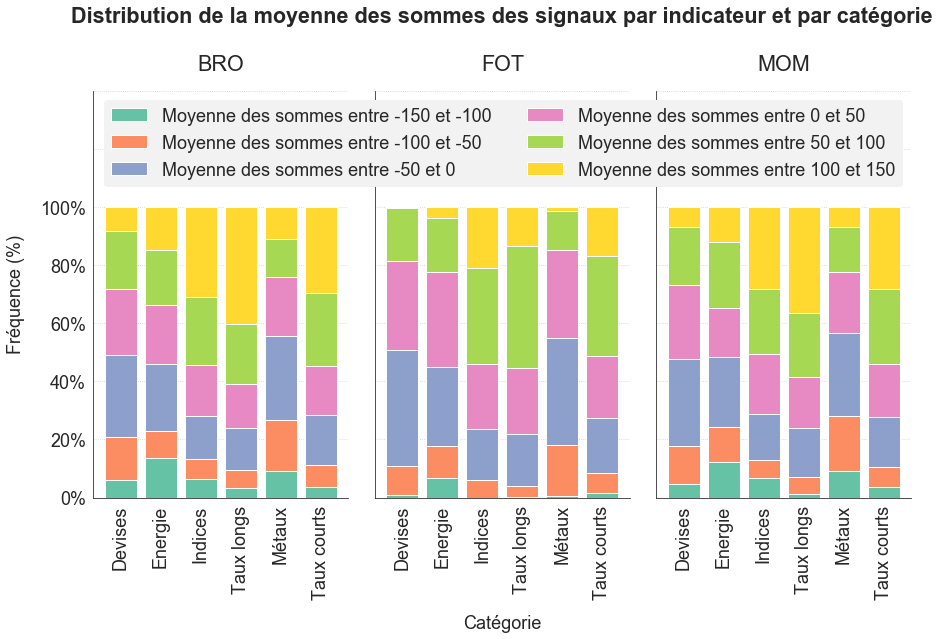

In [90]:
graph15 = sfg.MyGraph(title="Distribution de la moyenne des sommes des signaux par indicateur et par catégorie", nblin=1, nbcol=3)
cpt = 1
for indicateur in graph_data.trading_indicator.unique():
    for mybin in graph_data.bins.unique():
        graph15.add_barv(x_values=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.bins==mybin)].category_name, 
                         y_height=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.bins==mybin)].pourcentage_signaux,
                         y_bottom=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.bins==mybin)].pourcentage_cumule - 
                             graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.bins==mybin)].pourcentage_signaux,
                         label="Moyenne des sommes entre {:.0f} et {:.0f}".format(mybin.left, mybin.right), subtitle=indicateur, multi_index=cpt)
        graph15.set_axe('x', rotation=90, ha='center', multi_index=cpt)
        graph15.set_axe('y', tick_min=0, tick_max=1.4, tick_labels=[""], multi_index=cpt)
    cpt += 1
graph15.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"," "," "], multi_index=1)
graph15.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=1)
graph15.set_axe('x', label="Catégorie", tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=2)
graph15.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=3)
graph15.set_legend(loc="upper center", bbox_to_anchor=(-0.6,1), ncol=2, multi_index=3)
fig, ax = graph15.fig, graph15.ax
#plt.savefig("M1_distrib_moyenne_categorie_indicateur.png")
plt.show()

In [91]:
agreg_categorie_horizon = agreg_contrat_horizon.reset_index().groupby(["category_name","param_time_period","dateref"]).somme_signaux.mean().reset_index()
agreg_categorie_horizon.columns = ["category_name","param_time_period","dateref","moyenne_somme_signaux"]
agreg_categorie_horizon.head()

,category_name,param_time_period,dateref,moyenne_somme_signaux
0,Currencies,LT1,1989-06-01,0.0
1,Currencies,LT1,1989-06-02,0.0
2,Currencies,LT1,1989-06-06,0.0
3,Currencies,LT1,1989-06-07,0.0
4,Currencies,LT1,1989-06-08,0.0


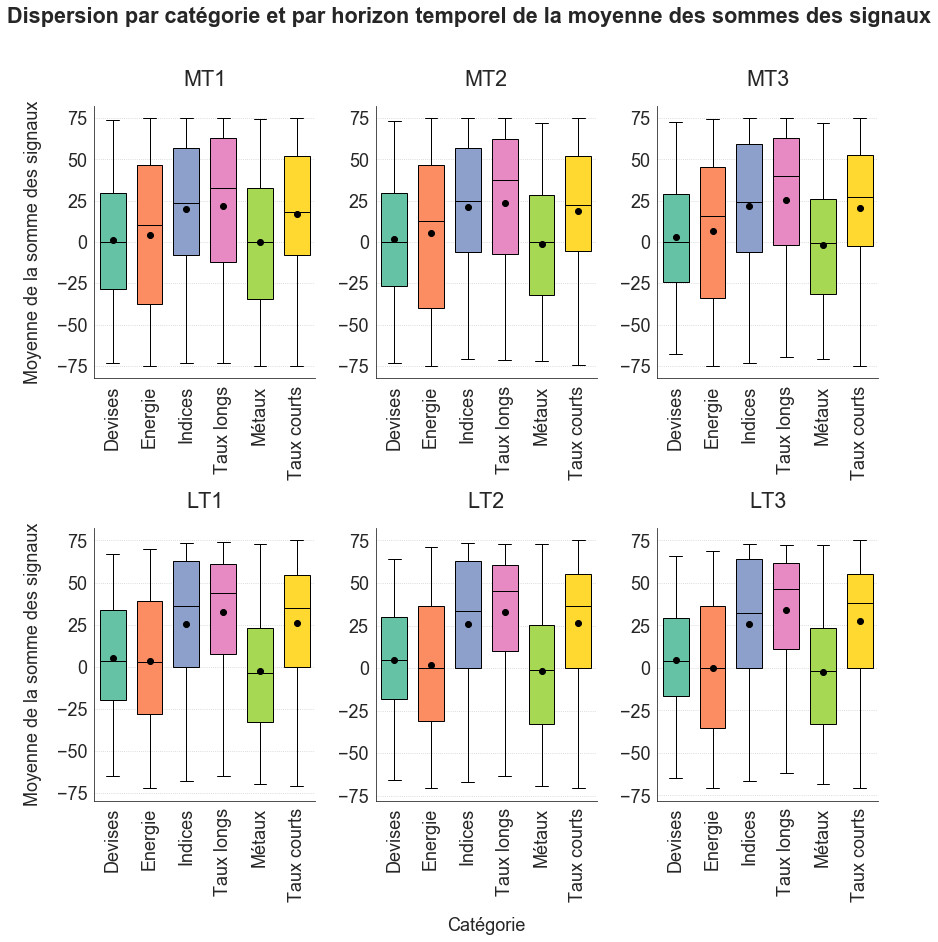

In [92]:
graph16 = sfg.MyGraph(title="Dispersion par catégorie et par horizon temporel de la moyenne des sommes des signaux", nblin=2, nbcol=3)
cpt = 1
for ptp in pd.Categorical(agreg_categorie_horizon.param_time_period.unique(), ptp_sort).categories.values:
    valeurs = [agreg_categorie_horizon[(agreg_categorie_horizon.category_name==cat) & (agreg_categorie_horizon.param_time_period==ptp)].moyenne_somme_signaux for cat in agreg_categorie_horizon.category_name.unique()]
    graph16.add_boxplot(values=valeurs, cat_labels=agreg_categorie_horizon.category_name.unique(), means=True, vertical=True, color_base_index=0, subtitle=ptp, multi_index=cpt)
    graph16.set_axe('x', rotation=90, ha='center', multi_index=cpt)
    cpt += 1
graph16.set_axe('y', label="Moyenne de la somme des signaux", multi_index=1)
graph16.set_axe('y', label="Moyenne de la somme des signaux", multi_index=4)
graph16.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=1)
graph16.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=2)
graph16.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=3)
graph16.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=4)
graph16.set_axe('x', label="Catégorie", tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=5)
graph16.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], multi_index=6)
fig, ax = graph16.fig, graph16.ax
#plt.savefig("M1_dispersion_moyenne_categorie_horizon.png")
plt.show()

In [93]:
interdata = agreg_categorie_horizon.groupby(["param_time_period","category_name","moyenne_somme_signaux"]).dateref.count().reset_index()
interdata.columns = ["param_time_period","category_name","moyenne_somme_signaux","nombre"]
interdata["bins"] = pd.cut(interdata.moyenne_somme_signaux, [-75,-50,-25,0,25,50,75], include_lowest=True)
interdata.head()

,param_time_period,category_name,moyenne_somme_signaux,nombre,bins
0,LT1,Currencies,-64.714286,6,"(-75.001, -50.0]"
1,LT1,Currencies,-64.571429,3,"(-75.001, -50.0]"
2,LT1,Currencies,-64.428571,3,"(-75.001, -50.0]"
3,LT1,Currencies,-64.285714,4,"(-75.001, -50.0]"
4,LT1,Currencies,-64.142857,2,"(-75.001, -50.0]"


In [94]:
graph_data = interdata.groupby(["param_time_period","category_name","bins"]).nombre.sum().reset_index()
graph_data["total"] = graph_data.groupby(["param_time_period","category_name"]).nombre.transform(pd.Series.sum)
graph_data["pourcentage_signaux"] = graph_data.nombre / graph_data.total
graph_data["pourcentage_cumule"] = graph_data.groupby(["param_time_period","category_name"]).pourcentage_signaux.cumsum()
graph_data['ptp'] = pd.Categorical(graph_data['param_time_period'], ptp_sort)
graph_data.sort_values(by=['ptp','category_name','bins'], inplace=True)
graph_data.head()

,param_time_period,category_name,bins,nombre,total,pourcentage_signaux,pourcentage_cumule,ptp
108,MT1,Currencies,"(-75.001, -50.0]",647,7787,0.083087,0.083087,MT1
109,MT1,Currencies,"(-50.0, -25.0]",1561,7787,0.200462,0.283550,MT1
110,MT1,Currencies,"(-25.0, 0.0]",1925,7787,0.247207,0.530756,MT1
111,MT1,Currencies,"(0.0, 25.0]",1423,7787,0.182740,0.713497,MT1
112,MT1,Currencies,"(25.0, 50.0]",1268,7787,0.162835,0.876332,MT1


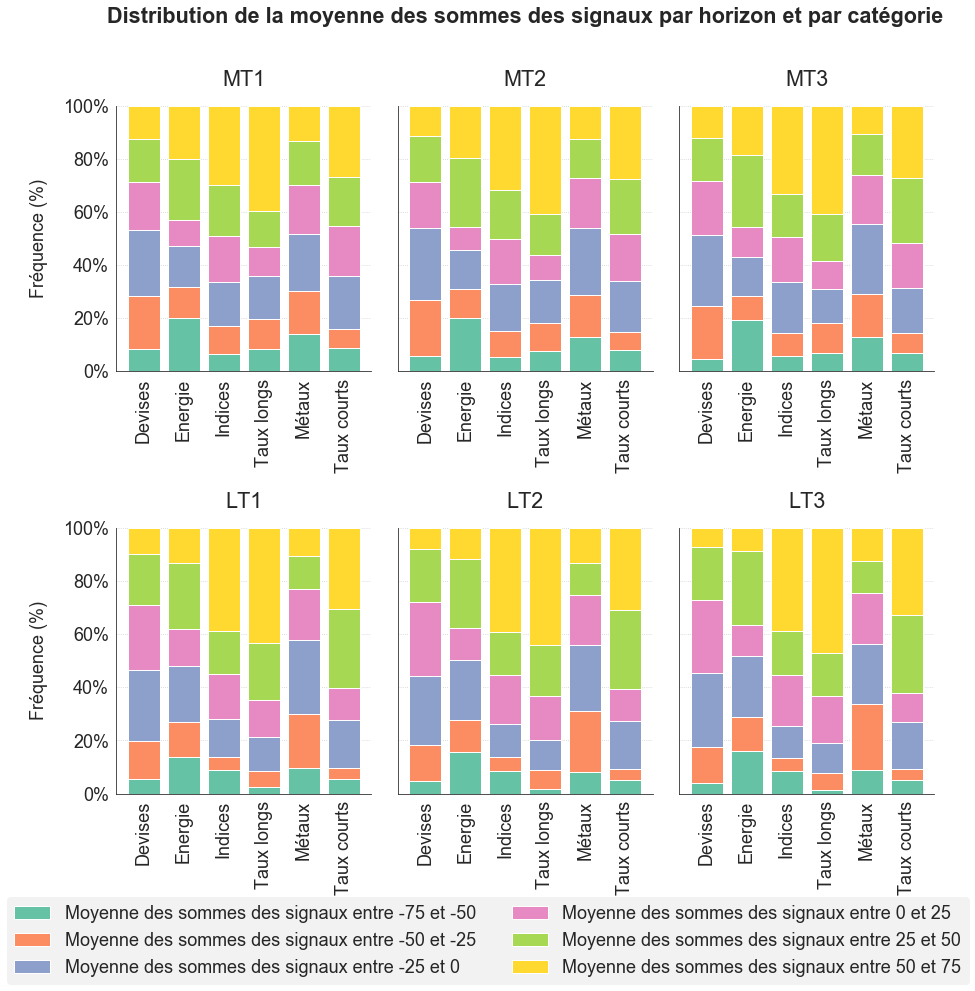

In [95]:
graph17 = sfg.MyGraph(title="Distribution de la moyenne des sommes des signaux par horizon et par catégorie", nblin=2, nbcol=3)
cpt = 1
for ptp in pd.Categorical(graph_data.param_time_period.unique(), ptp_sort).categories.values:
    for mybin in graph_data.bins.unique():
        graph17.add_barv(x_values=graph_data[(graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].category_name, 
                         y_height=graph_data[(graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         y_bottom=graph_data[(graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_cumule - 
                             graph_data[(graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         label="Moyenne des sommes des signaux entre {:.0f} et {:.0f}".format(mybin.left, mybin.right), subtitle=ptp, multi_index=cpt)
        graph17.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], rotation=90, ha='center', multi_index=cpt)
        graph17.set_axe('y', tick_min=0, tick_max=1.0, tick_labels=[""], multi_index=cpt)
    cpt += 1
graph17.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=1)
graph17.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=4)
graph17.set_legend(loc="lower center", bbox_to_anchor=(-0.75,-0.75), ncol=2, multi_index=6)
fig, ax = graph17.fig, graph17.ax
#plt.savefig("M1_distrib_moyenne_categorie_horizon.png")
plt.show()

In [96]:
agreg_contrat_precis = signals.groupby(["trading_indicator","param_time_period","category_name","contract_id","dateref"]).snl_signal.sum().reset_index()
agreg_contrat_precis.columns = ["trading_indicator","param_time_period","category_name","contract_id","dateref","somme_signaux"]
agreg_contrat_precis.head()

,trading_indicator,param_time_period,category_name,contract_id,dateref,somme_signaux
0,BRO,LT1,Currencies,1,1989-11-01,0
1,BRO,LT1,Currencies,1,1989-11-02,0
2,BRO,LT1,Currencies,1,1989-11-03,0
3,BRO,LT1,Currencies,1,1989-11-06,0
4,BRO,LT1,Currencies,1,1989-11-07,0


In [97]:
agreg_categorie_precis = agreg_contrat_precis.groupby(["trading_indicator","param_time_period","category_name","dateref"]).somme_signaux.mean().reset_index()
agreg_categorie_precis.columns = ["trading_indicator","param_time_period","category_name","dateref","moyenne_somme_signaux"]
agreg_categorie_precis.head()

,trading_indicator,param_time_period,category_name,dateref,moyenne_somme_signaux
0,BRO,LT1,Currencies,1989-06-01,0.0
1,BRO,LT1,Currencies,1989-06-02,0.0
2,BRO,LT1,Currencies,1989-06-06,0.0
3,BRO,LT1,Currencies,1989-06-07,0.0
4,BRO,LT1,Currencies,1989-06-08,0.0


In [98]:
interdata = agreg_categorie_precis.groupby(["trading_indicator","param_time_period","category_name","moyenne_somme_signaux"]).dateref.count().reset_index()
interdata.columns = ["trading_indicator","param_time_period","category_name","moyenne_somme_signaux","nombre"]
interdata["bins"] = pd.cut(interdata.moyenne_somme_signaux, [-25,-17,-8,0,8,17,25], include_lowest=True)
interdata.head()

,trading_indicator,param_time_period,category_name,moyenne_somme_signaux,nombre,bins
0,BRO,LT1,Currencies,-25.000000,8,"(-25.001, -17.0]"
1,BRO,LT1,Currencies,-24.833333,5,"(-25.001, -17.0]"
2,BRO,LT1,Currencies,-24.285714,107,"(-25.001, -17.0]"
3,BRO,LT1,Currencies,-24.142857,4,"(-25.001, -17.0]"
4,BRO,LT1,Currencies,-23.857143,2,"(-25.001, -17.0]"


In [99]:
graph_data = interdata.groupby(["trading_indicator","param_time_period","category_name","bins"]).nombre.sum().reset_index()
# action correctrice : ajout de lignes pour prendre en compte les catégories où la fréquence des bins est nulle pour l'indicateur FOT
newdata = pd.DataFrame([["FOT","LT1","LTIR",pd.Interval(left=-25.001, right=-17.0),0],\
                               ["FOT","LT2","LTIR",pd.Interval(left=-25.001, right=-17.0),0],\
                               ["FOT","LT3","Currencies",pd.Interval(left=-25.001, right=-17.0),0],\
                               ["FOT","LT3","Index",pd.Interval(left=-25.001, right=-17.0),0],\
                               ["FOT","LT3","LTIR",pd.Interval(left=-25.001, right=-17.0),0]], \
                      columns=["trading_indicator","param_time_period","category_name","bins","nombre"])
graph_data = graph_data.append(newdata, ignore_index=True)
# fin action correctrice
graph_data["total"] = graph_data.groupby(["trading_indicator","param_time_period","category_name"]).nombre.transform(pd.Series.sum)
graph_data["pourcentage_signaux"] = graph_data.nombre / graph_data.total
graph_data["pourcentage_cumule"] = graph_data.groupby(["trading_indicator","param_time_period","category_name"]).pourcentage_signaux.cumsum()
graph_data["ptp"] = pd.Categorical(graph_data["param_time_period"], ptp_sort)
graph_data.sort_values(by=["trading_indicator","ptp","category_name","bins"], inplace=True)
graph_data.head()

,trading_indicator,param_time_period,category_name,bins,nombre,total,pourcentage_signaux,pourcentage_cumule,ptp
108,BRO,MT1,Currencies,"(-25.001, -17.0]",1011,7787,0.129832,0.129832,MT1
109,BRO,MT1,Currencies,"(-17.0, -8.0]",1406,7787,0.180557,0.310389,MT1
110,BRO,MT1,Currencies,"(-8.0, 0.0]",1796,7787,0.230641,0.541030,MT1
111,BRO,MT1,Currencies,"(0.0, 8.0]",1162,7787,0.149223,0.690253,MT1
112,BRO,MT1,Currencies,"(8.0, 17.0]",1246,7787,0.160010,0.850263,MT1


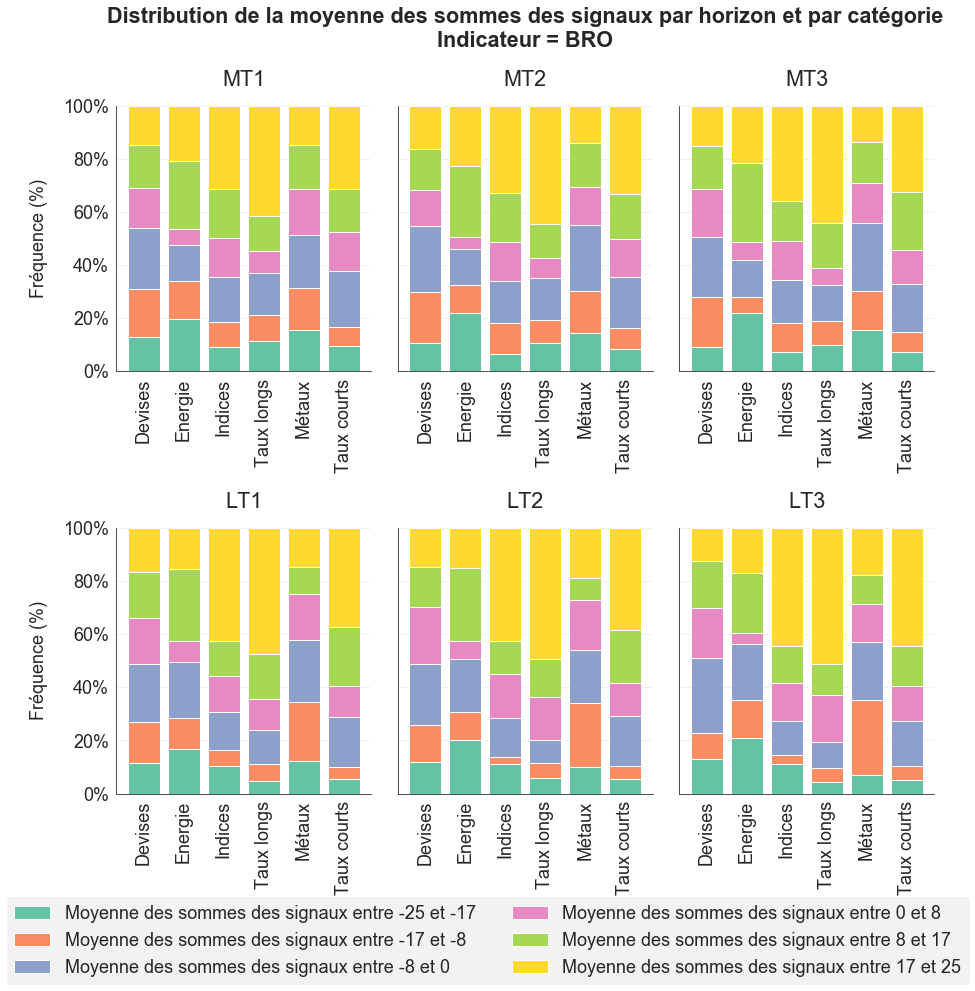

In [100]:
indicateur = 'BRO'
graph18 = sfg.MyGraph(title="Distribution de la moyenne des sommes des signaux par horizon et par catégorie\nIndicateur = {}".format(indicateur), nblin=2, nbcol=3)
cpt = 1
for ptp in pd.Categorical(graph_data.param_time_period.unique(), ptp_sort).categories.values:
    for mybin in graph_data.bins.unique():
        graph18.add_barv(x_values=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].category_name, 
                         y_height=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         y_bottom=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_cumule - 
                             graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         label="Moyenne des sommes des signaux entre {:.0f} et {:.0f}".format(mybin.left, mybin.right), subtitle=ptp, multi_index=cpt)
        graph18.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], rotation=90, ha='center', multi_index=cpt)
        graph18.set_axe('y', tick_min=0, tick_max=1.0, tick_labels=[""], multi_index=cpt)
    cpt += 1
graph18.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=1)
graph18.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=4)
graph18.set_legend(loc="lower center", bbox_to_anchor=(-0.75,-0.75), ncol=2, multi_index=6)
fig, ax = graph18.fig, graph18.ax
#plt.savefig("M1_distrib_moyenne_BRO_categorie_horizon.png")
plt.show()

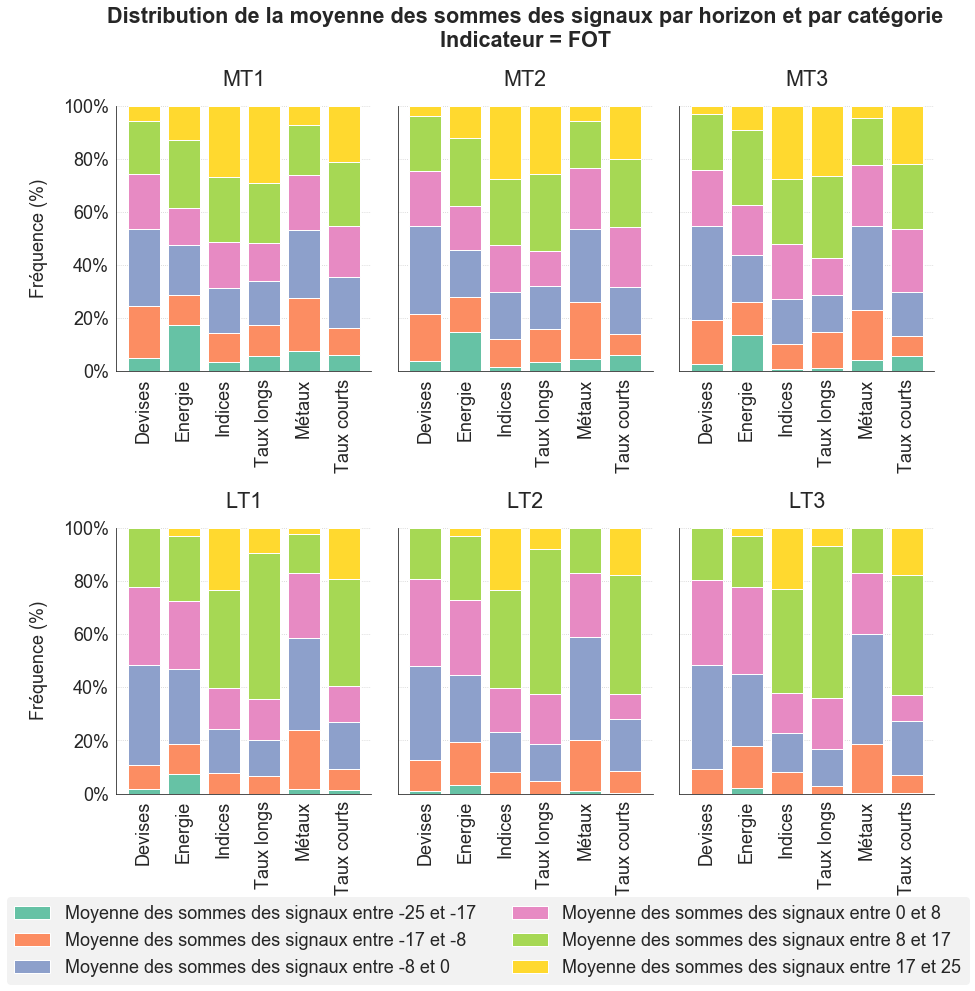

In [101]:
indicateur = 'FOT'
graph19 = sfg.MyGraph(title="Distribution de la moyenne des sommes des signaux par horizon et par catégorie\nIndicateur = {}".format(indicateur), nblin=2, nbcol=3)
cpt = 1
for ptp in pd.Categorical(graph_data.param_time_period.unique(), ptp_sort).categories.values:
    for mybin in graph_data.bins.unique():
        graph19.add_barv(x_values=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].category_name, 
                         y_height=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         y_bottom=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_cumule - 
                             graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         label="Moyenne des sommes des signaux entre {:.0f} et {:.0f}".format(mybin.left, mybin.right), subtitle=ptp, multi_index=cpt)
        graph19.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], rotation=90, ha='center', multi_index=cpt)
        graph19.set_axe('y', tick_min=0, tick_max=1.0, tick_labels=[""], multi_index=cpt)
    cpt += 1
graph19.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=1)
graph19.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=4)
graph19.set_legend(loc="lower center", bbox_to_anchor=(-0.75,-0.75), ncol=2, multi_index=6)
fig, ax = graph19.fig, graph19.ax
#plt.savefig("M1_distrib_moyenne_FOT_categorie_horizon.png")
plt.show()

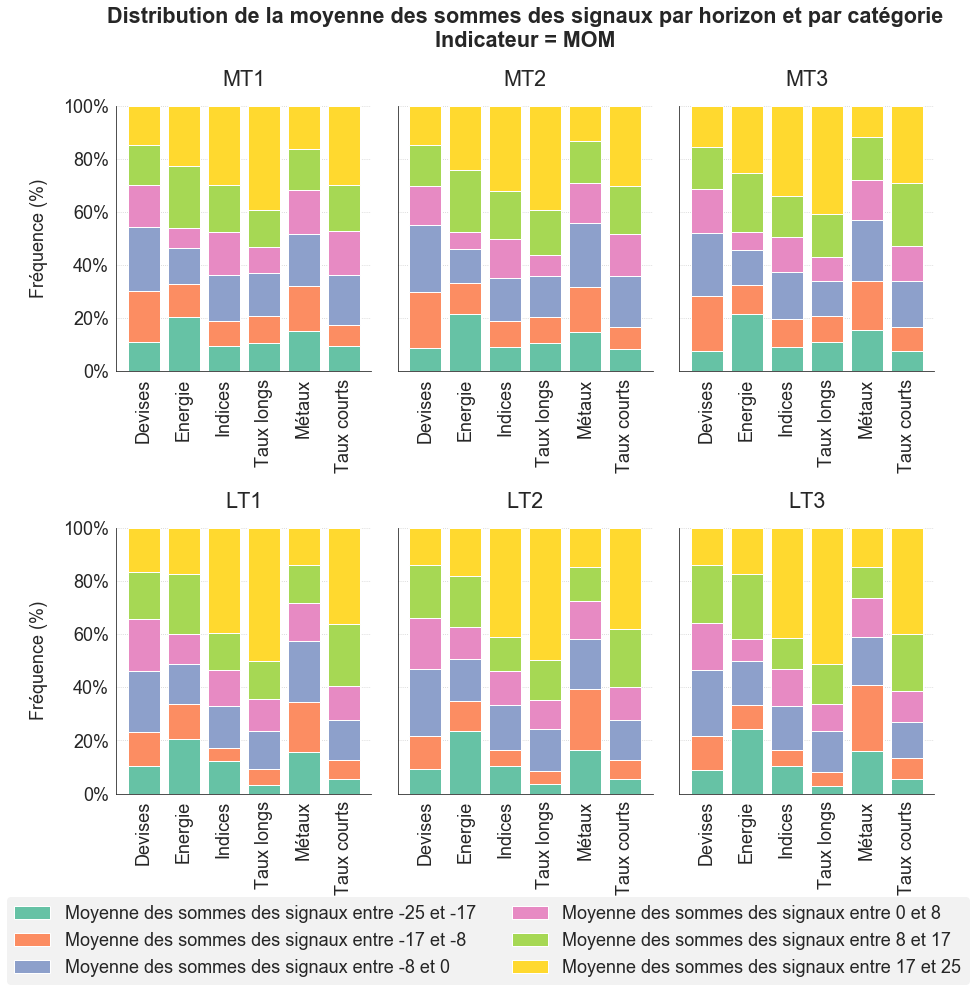

In [102]:
indicateur = 'MOM'
graph20 = sfg.MyGraph(title="Distribution de la moyenne des sommes des signaux par horizon et par catégorie\nIndicateur = {}".format(indicateur), nblin=2, nbcol=3)
cpt = 1
for ptp in pd.Categorical(graph_data.param_time_period.unique(), ptp_sort).categories.values:
    for mybin in graph_data.bins.unique():
        graph20.add_barv(x_values=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].category_name, 
                         y_height=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         y_bottom=graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_cumule - 
                             graph_data[(graph_data.trading_indicator==indicateur) & (graph_data.param_time_period==ptp) & (graph_data.bins==mybin)].pourcentage_signaux,
                         label="Moyenne des sommes des signaux entre {:.0f} et {:.0f}".format(mybin.left, mybin.right), subtitle=ptp, multi_index=cpt)
        graph20.set_axe('x', tick_labels=["Devises","Energie","Indices","Taux longs","Métaux","Taux courts"], rotation=90, ha='center', multi_index=cpt)
        graph20.set_axe('y', tick_min=0, tick_max=1.0, tick_labels=[""], multi_index=cpt)
    cpt += 1
graph20.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=1)
graph20.set_axe('y', label="Fréquence (%)", tick_labels=["0%","20%","40%","60%","80%","100%"], multi_index=4)
graph20.set_legend(loc="lower center", bbox_to_anchor=(-0.75,-0.75), ncol=2, multi_index=6)
fig, ax = graph20.fig, graph20.ax
#plt.savefig("M1_distrib_moyenne_MOM_categorie_horizon.png")
plt.show()

In [103]:
#code utilisé pour vérifier les catégories pour l'indicateur FOT sur l'horizon LT3 (ou autre)
for mybin in graph_data.bins.unique():
    print("bin = {} ; catégories = {}".format(mybin, graph_data[(graph_data.trading_indicator=='FOT') & (graph_data.param_time_period=="LT3") & (graph_data.bins==mybin)].category_name.unique()))

bin = (-25.001, -17.0] ; catégories = ['Currencies' 'Energy' 'Index' 'LTIR' 'Metals' 'STIR']
bin = (-17.0, -8.0] ; catégories = ['Currencies' 'Energy' 'Index' 'LTIR' 'Metals' 'STIR']
bin = (-8.0, 0.0] ; catégories = ['Currencies' 'Energy' 'Index' 'LTIR' 'Metals' 'STIR']
bin = (0.0, 8.0] ; catégories = ['Currencies' 'Energy' 'Index' 'LTIR' 'Metals' 'STIR']
bin = (8.0, 17.0] ; catégories = ['Currencies' 'Energy' 'Index' 'LTIR' 'Metals' 'STIR']
bin = (17.0, 25.0] ; catégories = ['Currencies' 'Energy' 'Index' 'LTIR' 'Metals' 'STIR']


<a id='1_4'></a>

### 1.4. Préparation d'un dataframe avec l'évolution future des prix à partir d'une date donnée

In [104]:
prices_evolution = pd.read_csv("prices_evolution.csv", index_col=0, parse_dates=["dateref"])
prices_evolution.head()

,contract_id,dateref,close_price,mid_price,real_price,variation_01_pourcent,variation_21_pourcent,variation_42_pourcent,variation_64_pourcent,volatilite_21,volatilite_42,volatilite_64,variation_21_standard,variation_42_standard,variation_64_standard
0,1,1989-11-01,28.12,28.070,75.50,-0.004371,0.005298,0.026358,0.005166,0.064441,0.069941,0.090376,0.082215,0.376857,0.057156
1,1,1989-11-02,27.79,27.905,75.17,0.003459,0.015565,0.024079,0.009445,0.064867,0.071130,0.089921,0.239948,0.338517,0.105039
2,1,1989-11-03,28.05,27.935,75.43,0.005303,0.012727,0.023465,-0.004242,0.064099,0.070993,0.091989,0.198553,0.330530,-0.046118
3,1,1989-11-06,28.45,28.360,75.83,0.000923,0.006066,0.019254,-0.013715,0.062027,0.069996,0.091715,0.097800,0.275066,-0.149538
4,1,1989-11-07,28.52,28.570,75.90,0.002635,0.005665,0.022134,-0.021080,0.061990,0.070459,0.092558,0.091391,0.314145,-0.227753


In [105]:
prices_evolution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360539 entries, 0 to 360538
Data columns (total 15 columns):
contract_id              360539 non-null int64
dateref                  360539 non-null datetime64[ns]
close_price              360539 non-null float64
mid_price                360539 non-null float64
real_price               360539 non-null float64
variation_01_pourcent    360488 non-null float64
variation_21_pourcent    359468 non-null float64
variation_42_pourcent    358397 non-null float64
variation_64_pourcent    357275 non-null float64
volatilite_21            359468 non-null float64
volatilite_42            358397 non-null float64
volatilite_64            357275 non-null float64
variation_21_standard    359468 non-null float64
variation_42_standard    358397 non-null float64
variation_64_standard    357275 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(1)
memory usage: 44.0 MB


In [106]:
analyse_21jours = agreg_contrat.reset_index().merge(prices_evolution[["contract_id","dateref","variation_21_standard"]], \
                                                   how='left', on=["contract_id","dateref"])
analyse_21jours.head()

,category_name,contract_id,dateref,somme_signaux,variation_21_standard
0,Currencies,1,1989-11-01,0,0.082215
1,Currencies,1,1989-11-02,0,0.239948
2,Currencies,1,1989-11-03,0,0.198553
3,Currencies,1,1989-11-06,0,0.097800
4,Currencies,1,1989-11-07,0,0.091391


In [107]:
analyse_42jours = agreg_contrat.reset_index().merge(prices_evolution[["contract_id","dateref","variation_42_standard"]], \
                                                   how='left', on=["contract_id","dateref"])
analyse_42jours.head()

,category_name,contract_id,dateref,somme_signaux,variation_42_standard
0,Currencies,1,1989-11-01,0,0.376857
1,Currencies,1,1989-11-02,0,0.338517
2,Currencies,1,1989-11-03,0,0.330530
3,Currencies,1,1989-11-06,0,0.275066
4,Currencies,1,1989-11-07,0,0.314145


In [108]:
analyse_64jours = agreg_contrat.reset_index().merge(prices_evolution[["contract_id","dateref","variation_64_standard"]], \
                                                   how='left', on=["contract_id","dateref"])
analyse_64jours.head()

,category_name,contract_id,dateref,somme_signaux,variation_64_standard
0,Currencies,1,1989-11-01,0,0.057156
1,Currencies,1,1989-11-02,0,0.105039
2,Currencies,1,1989-11-03,0,-0.046118
3,Currencies,1,1989-11-06,0,-0.149538
4,Currencies,1,1989-11-07,0,-0.227753


Note : J'ai un échec Memory Error pour la classification hiérarchique malgré plusieurs essais et recherches. Je me concentre donc sur le partitionnement par kmeans.

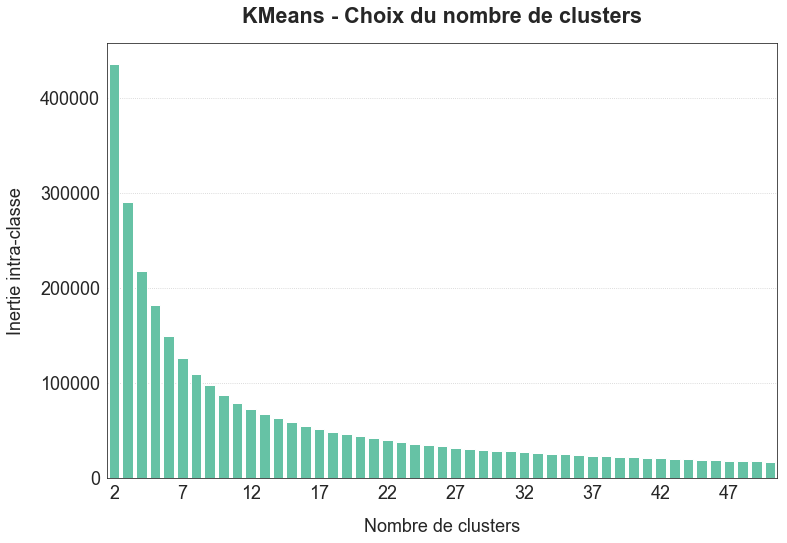

In [84]:
# Le calcul pour choisir entre 2 et 50 clusters est très long.
# Comme mon analyse m'amène à choisir dans un premier temps un partitionnement entre 8 et 12 clusters,
# je privilégie un calcul entre 2 et 20 clusters pour commencer.
#data_classif = analyse_21jours[["somme_signaux","variation_21_standard"]].dropna()
#kmeans21 = sfca.ClassificationKmeans(data_classif)
#kmeans21.calculate_kmeans(n_clust_min=2, n_clust_max=50)
#fig, ax = kmeans21.graphique_choix_nclusters()
#plt.show()

In [115]:
data_classif = analyse_21jours[["somme_signaux","variation_21_standard"]].dropna()
kmeans21 = sfca.ClassificationKmeans(data_classif)
kmeans21.calculate_kmeans(n_clust_min=2, n_clust_max=20)

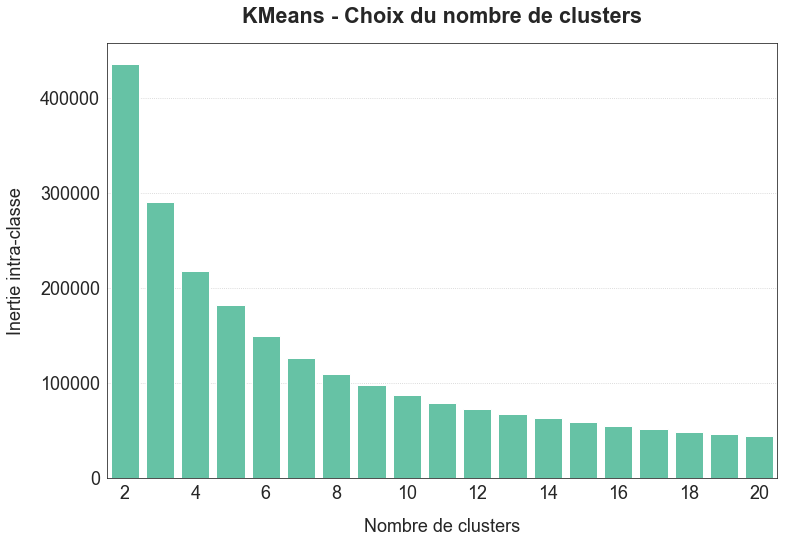

In [116]:
fig, ax = kmeans21.graphique_choix_nclusters()
plt.savefig("kmeans21_choixclusters.png")
plt.show()

In [117]:
data_classif = analyse_42jours[["somme_signaux","variation_42_standard"]].dropna()
kmeans42 = sfca.ClassificationKmeans(data_classif)
kmeans42.calculate_kmeans(n_clust_min=2, n_clust_max=20)

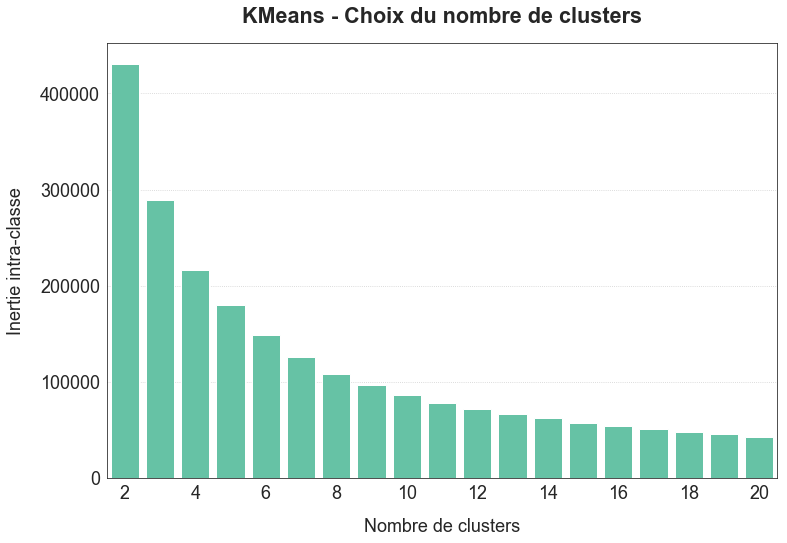

In [118]:
fig, ax = kmeans42.graphique_choix_nclusters()
plt.savefig("kmeans42_choixclusters.png")
plt.show()

In [119]:
data_classif = analyse_64jours[["somme_signaux","variation_64_standard"]].dropna()
kmeans64 = sfca.ClassificationKmeans(data_classif)
kmeans64.calculate_kmeans(n_clust_min=2, n_clust_max=20)

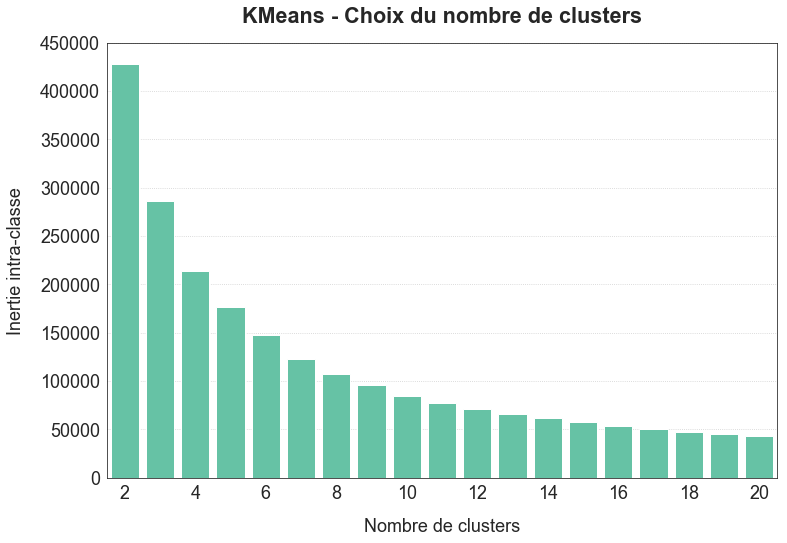

In [120]:
fig, ax = kmeans64.graphique_choix_nclusters()
plt.savefig("kmeans64_choixclusters.png")
plt.show()

Le graphique de choix du nombre de clusters m'amène à choisir entre 8 et 12 clusters selon la méthode du coude, quelque soit l'horizon de variation du prix.  
La connaissance métier, mêlée à la logique, m'amène à choisir 9 clusters. J'espère ainsi avoir une sorte de matrice 3x3 avec des regroupements nets sur l'axe de la somme des signaux d'une part, et sur l'axe de la variation du prix dans le futur d'autre part : valeurs fortement positives, valeurs neutres et valeurs fortement négatives.

In [121]:
kmeans21.define_n_clusters(9)
kmeans21.calculate_clusters_centroids()
resultats_kmeans21 = kmeans21.df_data_clusters.copy()
resultats_kmeans21.head()

,somme_signaux,variation_21_standard,cluster
0,0,0.082215,1
1,0,0.239948,7
2,0,0.198553,1
3,0,0.097800,1
4,0,0.091391,1


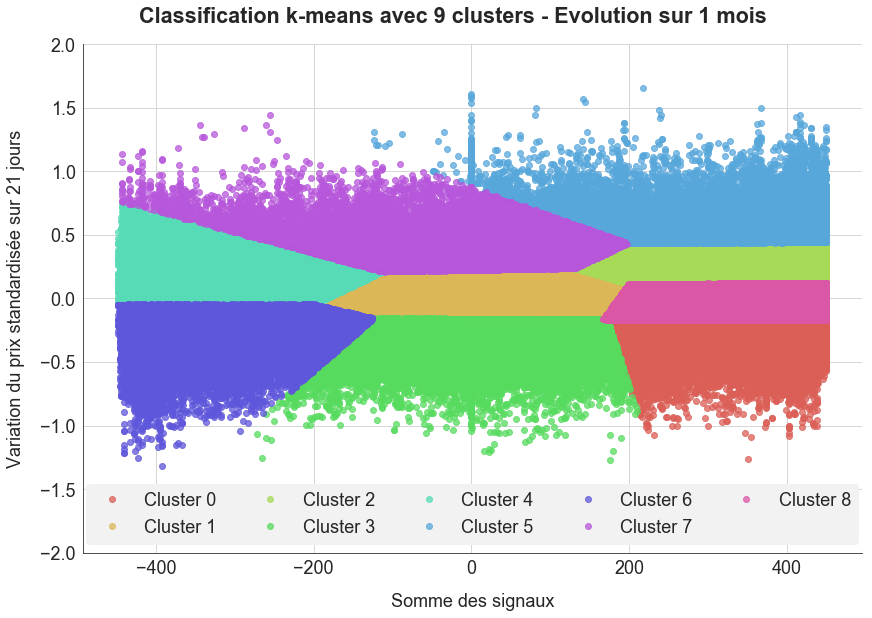

In [140]:
sns.set_palette(sns.color_palette("hls", 9))
liste_9couleurs = sns.color_palette()
graph21 = sfg.MyGraph(title="Classification k-means avec 9 clusters - Evolution sur 1 mois")
for i in np.sort(resultats_kmeans21.cluster.unique()):
    graph21.add_plot(x_values=resultats_kmeans21[resultats_kmeans21.cluster==i].somme_signaux, \
                     y_values=resultats_kmeans21[resultats_kmeans21.cluster==i].variation_21_standard, \
                     label="Cluster {}".format(i), color=liste_9couleurs[i], alpha=0.75, \
                     marker='o', linestyle='', with_grid='both')
graph21.set_axe('x', label="Somme des signaux")
graph21.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-2.0, tick_max=2.0)
graph21.set_legend(loc='lower center', ncol=5)
fig, ax = graph21.fig, graph21.ax
#plt.savefig("kmeans21_09partitions.png")
plt.show()

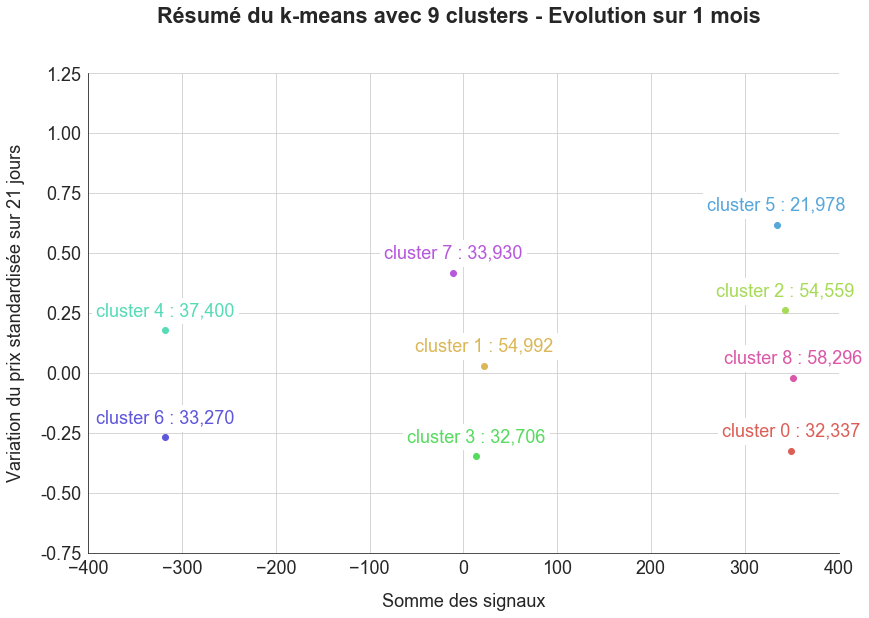

In [156]:
graph21b = sfg.MyGraph(title="Résumé du k-means avec 9 clusters - Evolution sur 1 mois")
for i in np.arange(len(kmeans21.df_centroids)):
    graph21b.add_plot(x_values=kmeans21.df_centroids.iloc[i].somme_signaux, \
         y_values=kmeans21.df_centroids.iloc[i].variation_21_standard, \
         label=kmeans21.df_centroids.index[i], color=liste_9couleurs[i], \
         marker='o', linestyle='', with_grid='both')
    graph21b.add_text(x_coord=kmeans21.df_centroids.iloc[i].somme_signaux, \
         y_coord=kmeans21.df_centroids.iloc[i].variation_21_standard+0.12, \
         text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
         color=liste_9couleurs[i], backgroundcolor=(1,1,1))
graph21b.set_axe('x', label="Somme des signaux", tick_min=-400, tick_max=400)
graph21b.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph21b.fig, graph21b.ax
#plt.savefig("kmeans21_09centroids.png")
plt.show()

In [142]:
kmeans42.define_n_clusters(9)
kmeans42.calculate_clusters_centroids()
resultats_kmeans42 = kmeans42.df_data_clusters.copy()
resultats_kmeans42.head()

,somme_signaux,variation_42_standard,cluster
0,0,0.376857,8
1,0,0.338517,8
2,0,0.330530,8
3,0,0.275066,8
4,0,0.314145,8


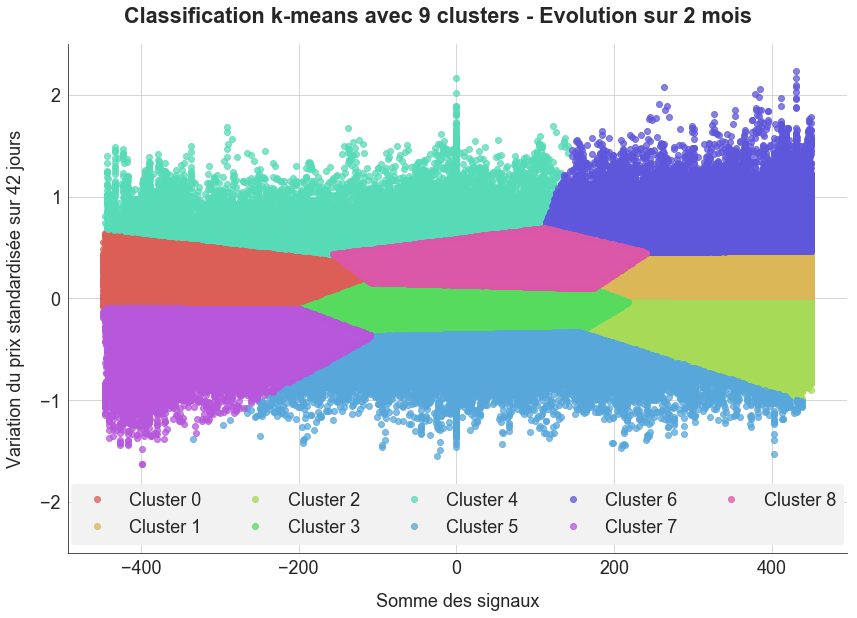

In [143]:
graph22 = sfg.MyGraph(title="Classification k-means avec 9 clusters - Evolution sur 2 mois")
for i in np.sort(resultats_kmeans42.cluster.unique()):
    graph22.add_plot(x_values=resultats_kmeans42[resultats_kmeans42.cluster==i].somme_signaux, \
                     y_values=resultats_kmeans42[resultats_kmeans42.cluster==i].variation_42_standard, \
                     label="Cluster {}".format(i), color=liste_9couleurs[i], alpha=0.75, \
                     marker='o', linestyle='', with_grid='both')
graph22.set_axe('x', label="Somme des signaux")
graph22.set_axe('y', label="Variation du prix standardisée sur 42 jours", tick_min=-2.5, tick_max=2.5)
graph22.set_legend(loc='lower center', ncol=5)
fig, ax = graph22.fig, graph22.ax
#plt.savefig("kmeans42_09partitions.png")
plt.show()

C:\Anaconda3\envs\Jupyter\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


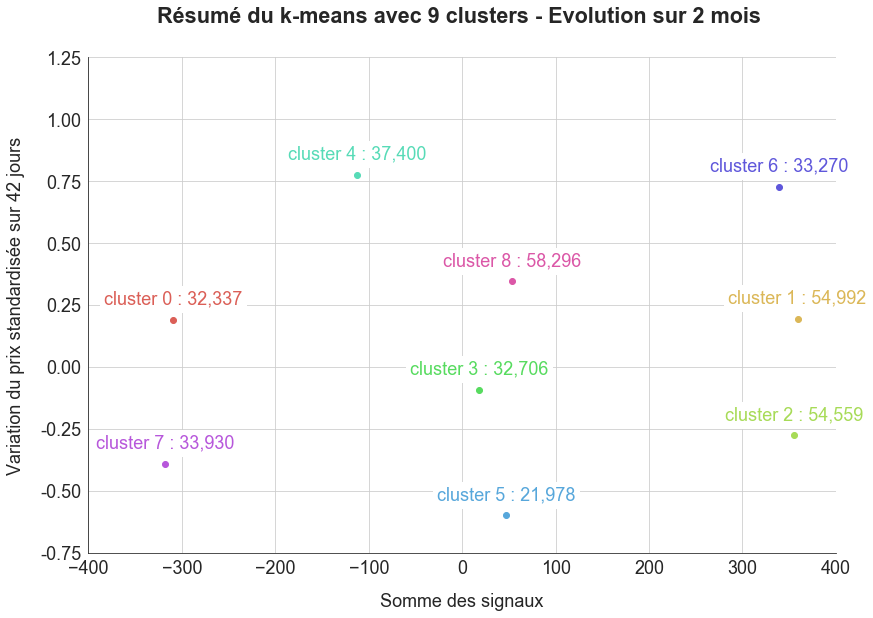

In [158]:
graph22b = sfg.MyGraph(title="Résumé du k-means avec 9 clusters - Evolution sur 2 mois")
for i in np.arange(len(kmeans42.df_centroids)):
    graph22b.add_plot(x_values=kmeans42.df_centroids.iloc[i].somme_signaux, \
         y_values=kmeans42.df_centroids.iloc[i].variation_42_standard, \
         label=kmeans42.df_centroids.index[i], color=liste_9couleurs[i], \
         marker='o', linestyle='', with_grid='both')
    graph22b.add_text(x_coord=kmeans42.df_centroids.iloc[i].somme_signaux, \
         y_coord=kmeans42.df_centroids.iloc[i].variation_42_standard+0.12, \
         text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
         color=liste_9couleurs[i], backgroundcolor=(1,1,1))
graph22b.set_axe('x', label="Somme des signaux", tick_min=-400, tick_max=400)
graph22b.set_axe('y', label="Variation du prix standardisée sur 42 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph22b.fig, graph22b.ax
#plt.savefig("kmeans42_09centroids.png")
plt.show()

In [150]:
kmeans64.define_n_clusters(9)
kmeans64.calculate_clusters_centroids()
resultats_kmeans64 = kmeans64.df_data_clusters.copy()
resultats_kmeans64.head()

,somme_signaux,variation_64_standard,cluster
0,0,0.057156,5
1,0,0.105039,5
2,0,-0.046118,5
3,0,-0.149538,5
4,0,-0.227753,5


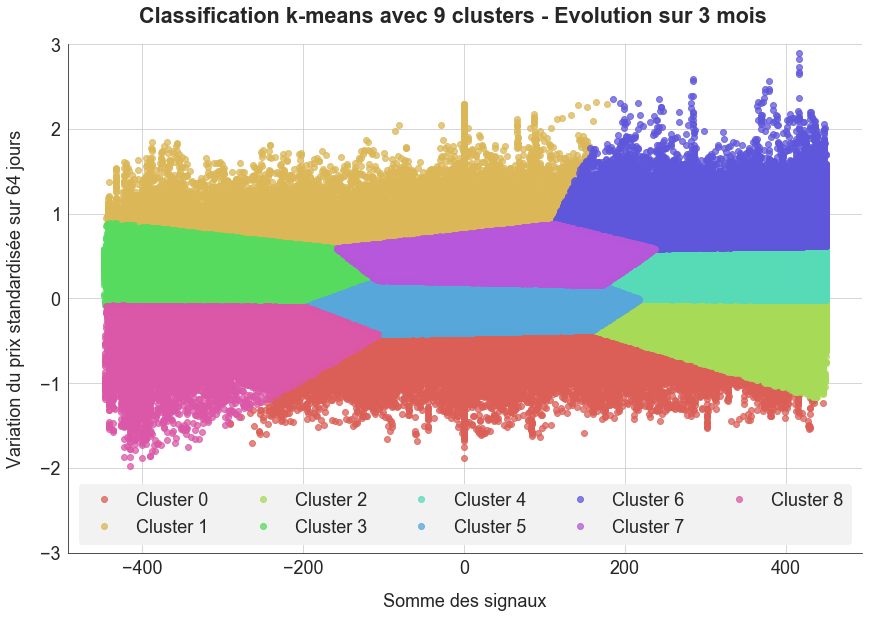

In [152]:
graph23 = sfg.MyGraph(title="Classification k-means avec 9 clusters - Evolution sur 3 mois")
for i in np.sort(resultats_kmeans64.cluster.unique()):
    graph23.add_plot(x_values=resultats_kmeans64[resultats_kmeans64.cluster==i].somme_signaux, \
         y_values=resultats_kmeans64[resultats_kmeans64.cluster==i].variation_64_standard, \
         label="Cluster {}".format(i), color=liste_9couleurs[i], alpha=0.75, \
         marker='o', linestyle='', with_grid='both')
graph23.set_axe('x', label="Somme des signaux")
graph23.set_axe('y', label="Variation du prix standardisée sur 64 jours", tick_min=-3.0, tick_max=3.0)
graph23.set_legend(loc='lower center', ncol=5)
fig, ax = graph23.fig, graph23.ax
#plt.savefig("kmeans64_09partitions.png")
plt.show()

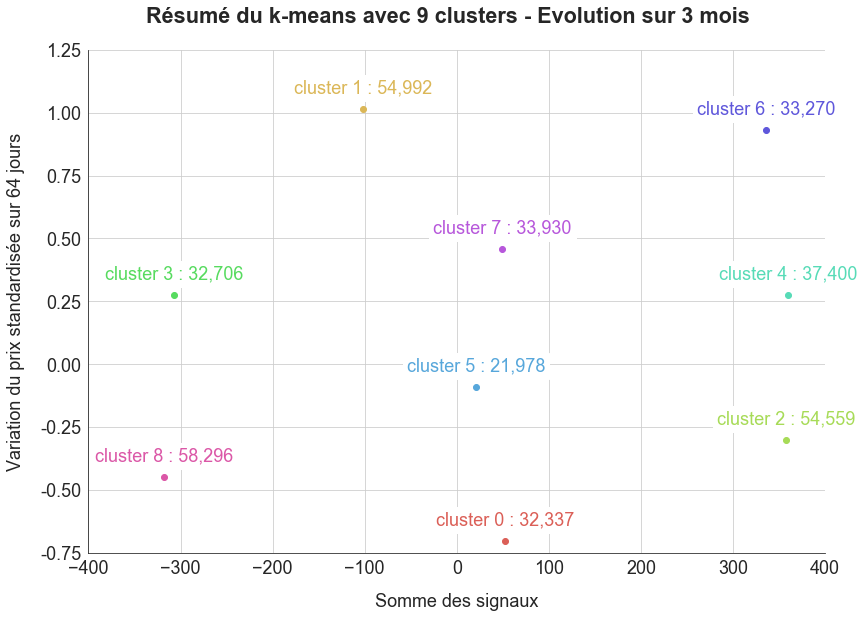

In [159]:
graph23b = sfg.MyGraph(title="Résumé du k-means avec 9 clusters - Evolution sur 3 mois")
for i in np.arange(len(kmeans64.df_centroids)):
    graph23b.add_plot(x_values=kmeans64.df_centroids.iloc[i].somme_signaux, \
         y_values=kmeans64.df_centroids.iloc[i].variation_64_standard, \
         label=kmeans64.df_centroids.index[i], color=liste_9couleurs[i], \
         marker='o', linestyle='', with_grid='both')
    graph23b.add_text(x_coord=kmeans64.df_centroids.iloc[i].somme_signaux, \
         y_coord=kmeans64.df_centroids.iloc[i].variation_64_standard+0.12, \
         text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
         color=liste_9couleurs[i], backgroundcolor=(1,1,1))
graph23b.set_axe('x', label="Somme des signaux", tick_min=-400, tick_max=400)
graph23b.set_axe('y', label="Variation du prix standardisée sur 64 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph23b.fig, graph23b.ax
#plt.savefig("kmeans64_09centroids.png")
plt.show()

Je n'obtiens la matrice espérée dans aucun des cas (à 1 mois, à 2 mois ou à 3 mois), avec seulement deux sommes des signaux très négatives. Je tente une partition à 10 clusters afin de voir si je peux obtenir cette partition en matrice 3x3 avec un cluster supplémentaire "libre".

In [160]:
kmeans21.define_n_clusters(10)
kmeans21.calculate_clusters_centroids()
resultats_kmeans21 = kmeans21.df_data_clusters.copy()
resultats_kmeans21.head()

,somme_signaux,variation_21_standard,cluster
0,0,0.082215,2
1,0,0.239948,8
2,0,0.198553,2
3,0,0.097800,2
4,0,0.091391,2


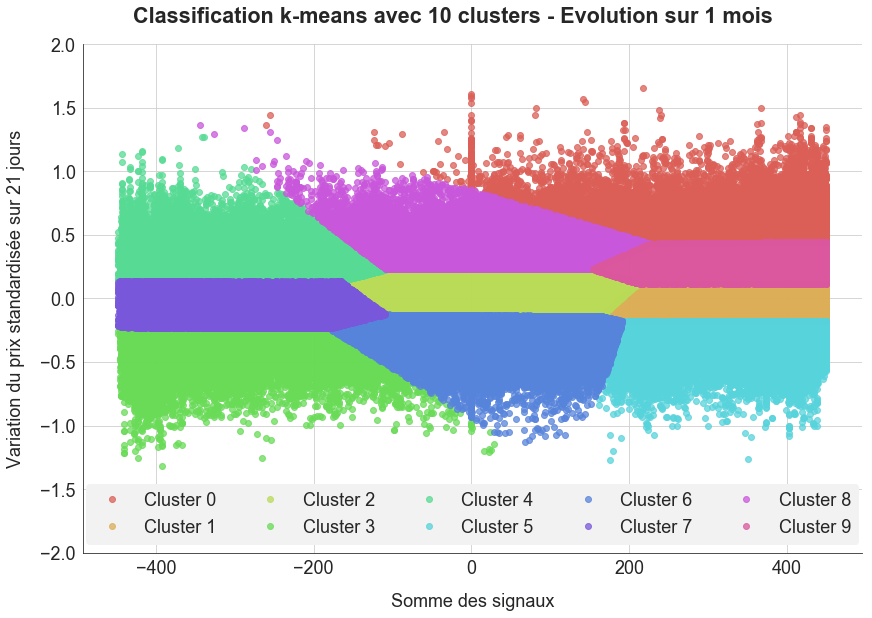

In [162]:
sns.set_palette(sns.color_palette("hls", 10))
liste_10couleurs = sns.color_palette()
graph21 = sfg.MyGraph(title="Classification k-means avec 10 clusters - Evolution sur 1 mois")
for i in np.sort(resultats_kmeans21.cluster.unique()):
    graph21.add_plot(x_values=resultats_kmeans21[resultats_kmeans21.cluster==i].somme_signaux, \
                     y_values=resultats_kmeans21[resultats_kmeans21.cluster==i].variation_21_standard, \
                     label="Cluster {}".format(i), color=liste_10couleurs[i], alpha=0.75, \
                     marker='o', linestyle='', with_grid='both')
graph21.set_axe('x', label="Somme des signaux")
graph21.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-2.0, tick_max=2.0)
graph21.set_legend(loc='lower center', ncol=5)
fig, ax = graph21.fig, graph21.ax
plt.savefig("kmeans21_10partitions.png")
plt.show()

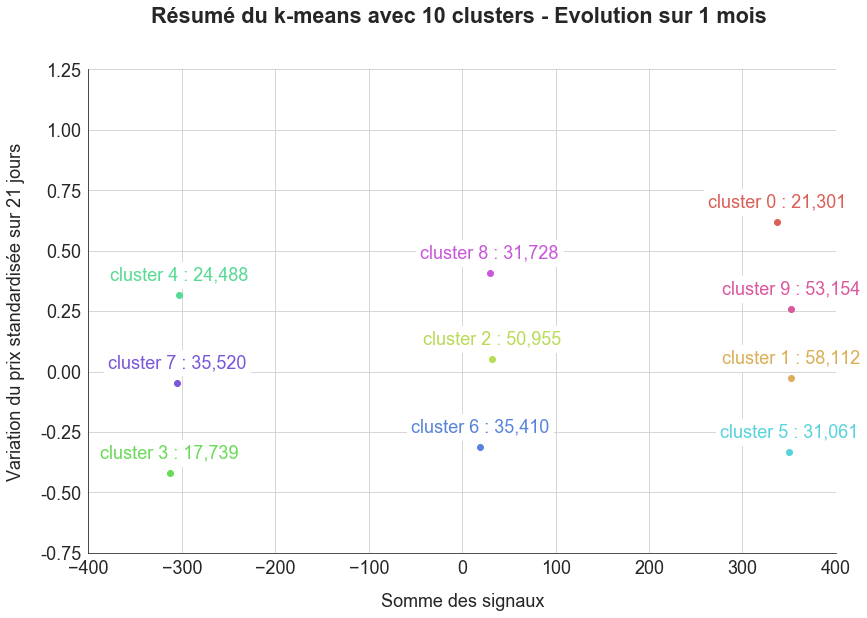

In [164]:
graph21b = sfg.MyGraph(title="Résumé du k-means avec 10 clusters - Evolution sur 1 mois")
for i in np.arange(len(kmeans21.df_centroids)):
    graph21b.add_plot(x_values=kmeans21.df_centroids.iloc[i].somme_signaux, \
         y_values=kmeans21.df_centroids.iloc[i].variation_21_standard, \
         label=kmeans21.df_centroids.index[i], color=liste_10couleurs[i], \
         marker='o', linestyle='', with_grid='both')
    graph21b.add_text(x_coord=kmeans21.df_centroids.iloc[i].somme_signaux, \
         y_coord=kmeans21.df_centroids.iloc[i].variation_21_standard+0.12, \
         text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
         color=liste_10couleurs[i], backgroundcolor=(1,1,1))
graph21b.set_axe('x', label="Somme des signaux", tick_min=-400, tick_max=400)
graph21b.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph21b.fig, graph21b.ax
plt.savefig("kmeans21_10centroids.png")
plt.show()

In [165]:
top_cluster21 = 0

In [166]:
kmeans42.define_n_clusters(10)
kmeans42.calculate_clusters_centroids()
resultats_kmeans42 = kmeans42.df_data_clusters.copy()
resultats_kmeans42.head()

,somme_signaux,variation_42_standard,cluster
0,0,0.376857,6
1,0,0.338517,6
2,0,0.330530,6
3,0,0.275066,6
4,0,0.314145,6


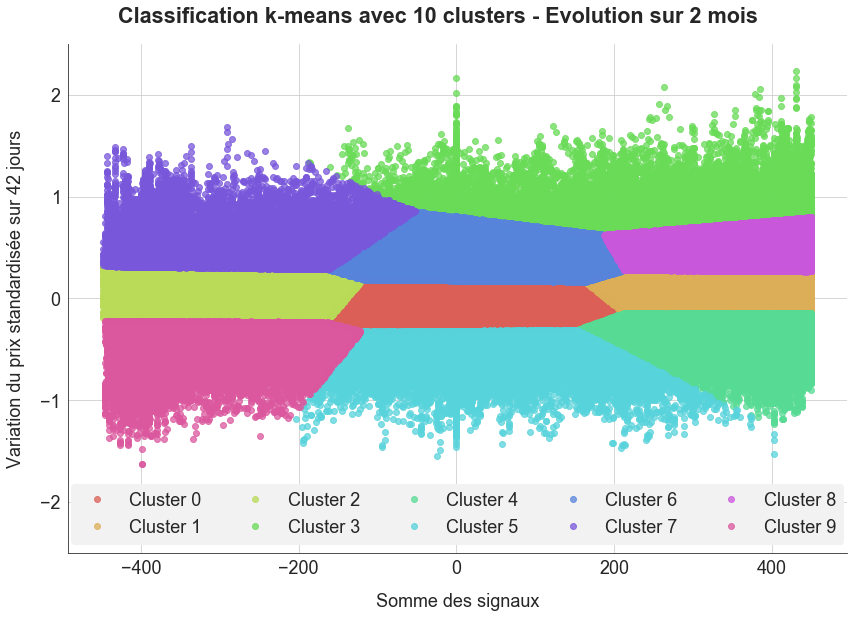

In [167]:
graph22 = sfg.MyGraph(title="Classification k-means avec 10 clusters - Evolution sur 2 mois")
for i in np.sort(resultats_kmeans42.cluster.unique()):
    graph22.add_plot(x_values=resultats_kmeans42[resultats_kmeans42.cluster==i].somme_signaux, \
                     y_values=resultats_kmeans42[resultats_kmeans42.cluster==i].variation_42_standard, \
                     label="Cluster {}".format(i), color=liste_10couleurs[i], alpha=0.75, \
                     marker='o', linestyle='', with_grid='both')
graph22.set_axe('x', label="Somme des signaux")
graph22.set_axe('y', label="Variation du prix standardisée sur 42 jours", tick_min=-2.5, tick_max=2.5)
graph22.set_legend(loc='lower center', ncol=5)
fig, ax = graph22.fig, graph22.ax
plt.savefig("kmeans42_10partitions.png")
plt.show()

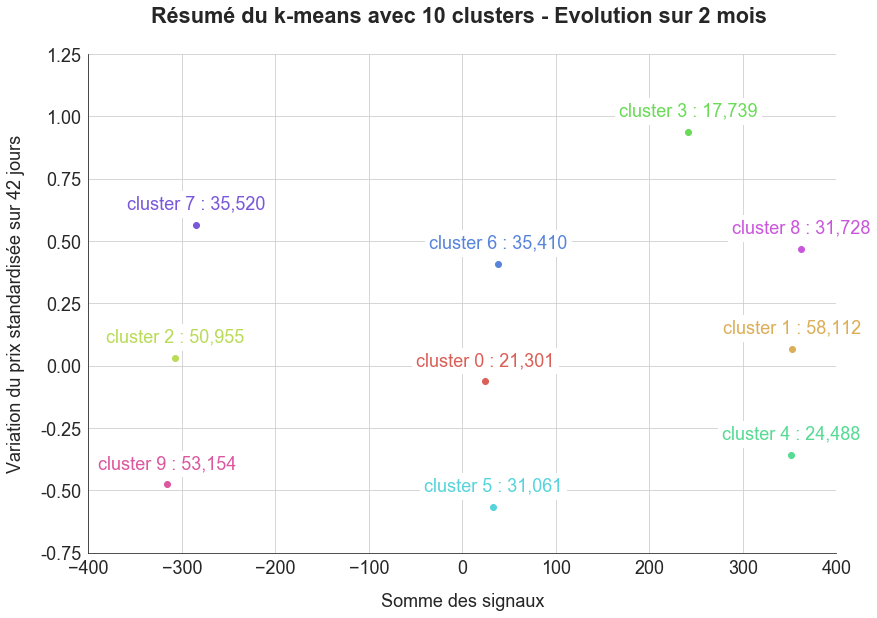

In [168]:
graph22b = sfg.MyGraph(title="Résumé du k-means avec 10 clusters - Evolution sur 2 mois")
for i in np.arange(len(kmeans42.df_centroids)):
    graph22b.add_plot(x_values=kmeans42.df_centroids.iloc[i].somme_signaux, \
         y_values=kmeans42.df_centroids.iloc[i].variation_42_standard, \
         label=kmeans42.df_centroids.index[i], color=liste_10couleurs[i], \
         marker='o', linestyle='', with_grid='both')
    graph22b.add_text(x_coord=kmeans42.df_centroids.iloc[i].somme_signaux, \
         y_coord=kmeans42.df_centroids.iloc[i].variation_42_standard+0.12, \
         text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
         color=liste_10couleurs[i], backgroundcolor=(1,1,1))
graph22b.set_axe('x', label="Somme des signaux", tick_min=-400, tick_max=400)
graph22b.set_axe('y', label="Variation du prix standardisée sur 42 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph22b.fig, graph22b.ax
plt.savefig("kmeans42_10centroids.png")
plt.show()

In [169]:
top_cluster42 = 3

J'étudie le pourcentage de positions gagnantes.  
Je considère qu'aucune position n'est prise pour les clusters dont la somme des signaux proche de 0 (clusters 0, 5 et 6). Les positions gagnantes sont celles des clusters 3, 8 et 9, parmi lesquelles les positions super-gagnantes sont celles du cluster 3.

In [197]:
nombre_total = kmeans42.df_centroids.nombre_individus.sum() - \
                kmeans42.df_centroids.iloc[0].nombre_individus - \
                kmeans42.df_centroids.iloc[5].nombre_individus - \
                kmeans42.df_centroids.iloc[6].nombre_individus
nombre_gagnant = kmeans42.df_centroids.iloc[3].nombre_individus + \
                kmeans42.df_centroids.iloc[8].nombre_individus + \
                kmeans42.df_centroids.iloc[9].nombre_individus
nombre_super_gagnant = kmeans42.df_centroids.iloc[3].nombre_individus
print("% de positions gagnantes = {:.2%} - dont super-gagnantes = {:.2%}".format(nombre_gagnant / nombre_total, nombre_super_gagnant / nombre_total))

% de positions gagnantes = 36.55% - dont super-gagnantes = 8.18%


36.6% des positions sont gagnantes, ce qui est un ratio correct pour un système suiveur de tendance. Les positions du cluster 3 (8.2% du total des positions prises) sont celles qui m'intéressent la plus car elles génèrent les plus gros gains.

In [170]:
kmeans64.define_n_clusters(10)
kmeans64.calculate_clusters_centroids()
resultats_kmeans64 = kmeans64.df_data_clusters.copy()
resultats_kmeans64.head()

,somme_signaux,variation_64_standard,cluster
0,0,0.057156,4
1,0,0.105039,4
2,0,-0.046118,4
3,0,-0.149538,4
4,0,-0.227753,4


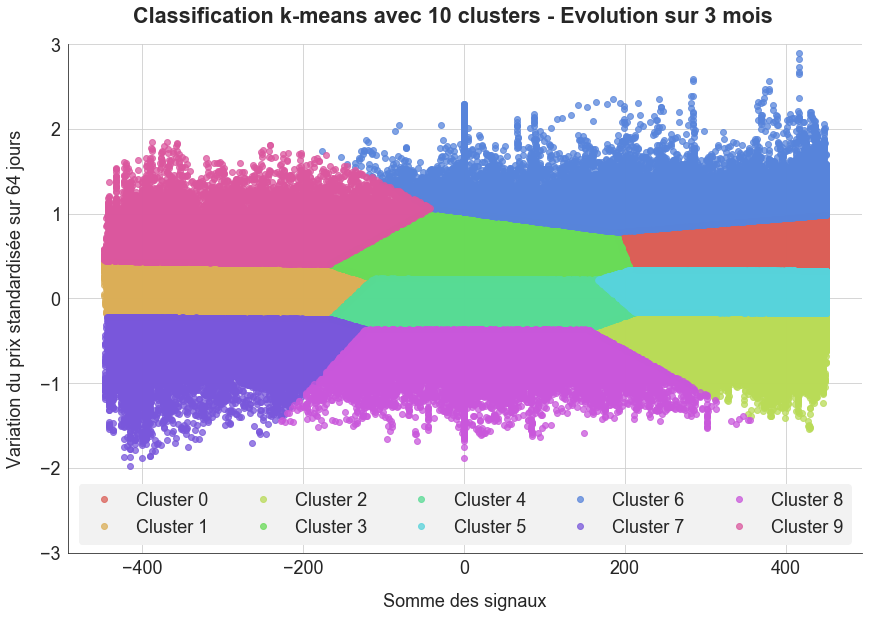

In [171]:
graph23 = sfg.MyGraph(title="Classification k-means avec 10 clusters - Evolution sur 3 mois")
for i in np.sort(resultats_kmeans64.cluster.unique()):
    graph23.add_plot(x_values=resultats_kmeans64[resultats_kmeans64.cluster==i].somme_signaux, \
                     y_values=resultats_kmeans64[resultats_kmeans64.cluster==i].variation_64_standard, \
                     label="Cluster {}".format(i), color=liste_10couleurs[i], alpha=0.75, \
                     marker='o', linestyle='', with_grid='both')
graph23.set_axe('x', label="Somme des signaux")
graph23.set_axe('y', label="Variation du prix standardisée sur 64 jours", tick_min=-3.0, tick_max=3.0)
graph23.set_legend(loc='lower center', ncol=5)
fig, ax = graph23.fig, graph23.ax
plt.savefig("kmeans64_10partitions.png")
plt.show()

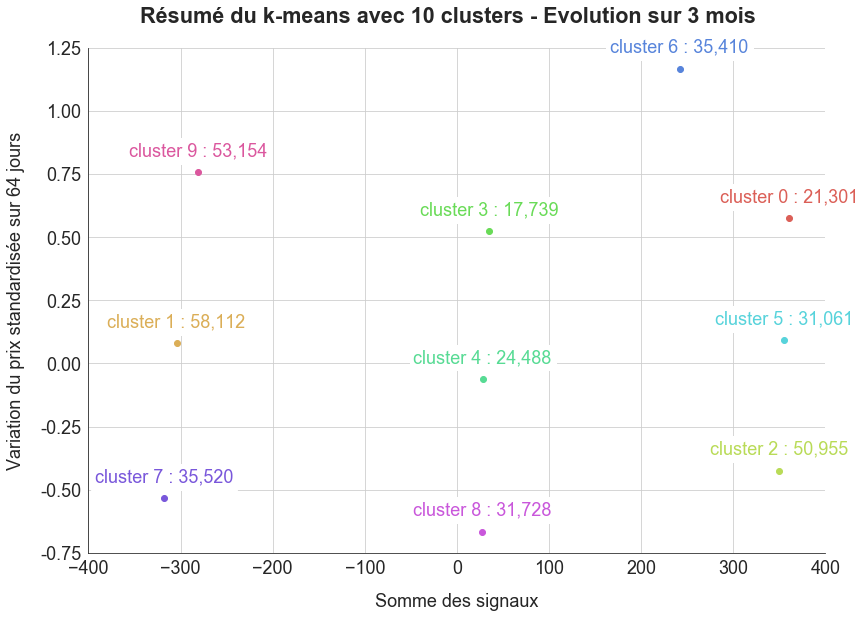

In [172]:
graph23b = sfg.MyGraph(title="Résumé du k-means avec 10 clusters - Evolution sur 3 mois")
for i in np.arange(len(kmeans64.df_centroids)):
    graph23b.add_plot(x_values=kmeans64.df_centroids.iloc[i].somme_signaux, \
         y_values=kmeans64.df_centroids.iloc[i].variation_64_standard, \
         label=kmeans64.df_centroids.index[i], color=liste_10couleurs[i], \
         marker='o', linestyle='', with_grid='both')
    graph23b.add_text(x_coord=kmeans64.df_centroids.iloc[i].somme_signaux, \
         y_coord=kmeans64.df_centroids.iloc[i].variation_64_standard+0.12, \
         text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
         color=liste_10couleurs[i], backgroundcolor=(1,1,1))
graph23b.set_axe('x', label="Somme des signaux", tick_min=-400, tick_max=400)
graph23b.set_axe('y', label="Variation du prix standardisée sur 64 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph23b.fig, graph23b.ax
plt.savefig("kmeans64_10centroids.png")
plt.show()

In [173]:
top_cluster64 = 6

J'étudie le pourcentage de positions gagnantes.  
Je considère qu'aucune position n'est prise pour les clusters dont la somme des signaux proche de 0 (clusters 3, 4 et 8). Les positions gagnantes sont celles des clusters 0, 6 et 7, parmi lesquelles les positions super-gagnantes sont celles du cluster 6.

In [198]:
nombre_total = kmeans64.df_centroids.nombre_individus.sum() - \
                kmeans64.df_centroids.iloc[3].nombre_individus - \
                kmeans64.df_centroids.iloc[4].nombre_individus - \
                kmeans64.df_centroids.iloc[8].nombre_individus
nombre_gagnant = kmeans64.df_centroids.iloc[0].nombre_individus + \
                kmeans64.df_centroids.iloc[6].nombre_individus + \
                kmeans64.df_centroids.iloc[7].nombre_individus
nombre_super_gagnant = kmeans64.df_centroids.iloc[6].nombre_individus
print("% de positions gagnantes = {:.2%} - dont super-gagnantes = {:.2%}".format(nombre_gagnant / nombre_total, nombre_super_gagnant / nombre_total))

% de positions gagnantes = 38.61% - dont super-gagnantes = 8.82%


38.6% des positions sont gagnantes, ce qui est un bon ratio pour un système suiveur de tendance. Les positions du cluster 6 (8.8% du total des positions prises) sont celles qui m'intéressent la plus car elles génèrent les plus gros gains.

Je peux maintenant tester avec 25 clusters, toujours dans la même logique d'essayer d'avoir des regroupements par valeurs. J'espère cette fois obtenir une matrice de partitionnement plus fine 5x5 en ajoutant des valeurs moyennement positives et moyennement négatives à la matrice précédente.

In [179]:
data_classif = analyse_21jours[["somme_signaux","variation_21_standard"]].dropna()
kmeans21b = sfca.ClassificationKmeans(data_classif)
kmeans21b.calculate_kmeans(n_clust_min=24, n_clust_max=26)

In [180]:
kmeans21b.define_n_clusters(25)
kmeans21b.calculate_clusters_centroids()
resultats_kmeans21b = kmeans21b.df_data_clusters.copy()
resultats_kmeans21b.head()

,somme_signaux,variation_21_standard,cluster
0,0,0.082215,15
1,0,0.239948,3
2,0,0.198553,3
3,0,0.097800,15
4,0,0.091391,15


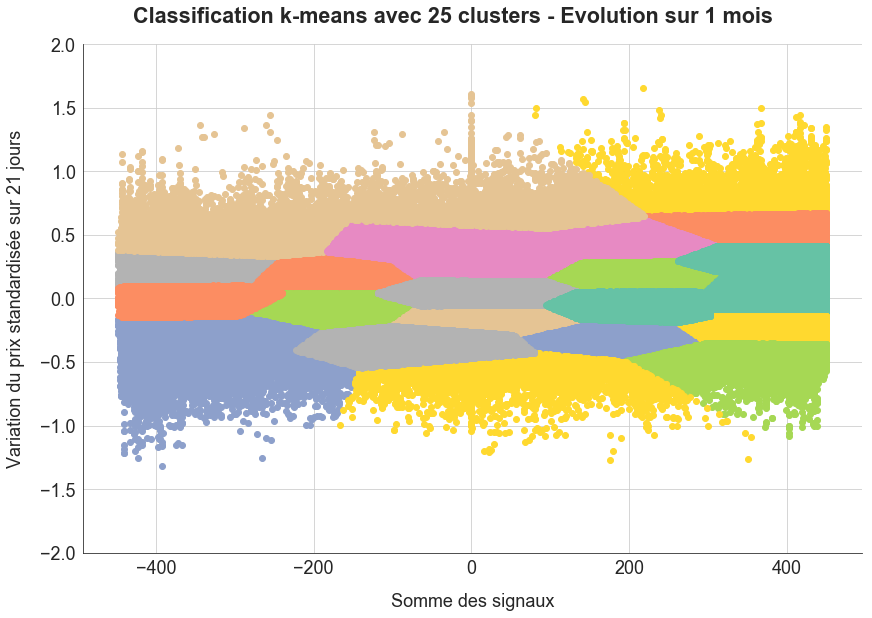

In [181]:
graph21 = sfg.MyGraph(title="Classification k-means avec 25 clusters - Evolution sur 1 mois")
for i in np.sort(resultats_kmeans21b.cluster.unique()):
    graph21.add_plot(x_values=resultats_kmeans21b[resultats_kmeans21b.cluster==i].somme_signaux, \
                     y_values=resultats_kmeans21b[resultats_kmeans21b.cluster==i].variation_21_standard, \
                     label="Cluster {}".format(i), marker='o', linestyle='', with_grid='both')
graph21.set_axe('x', label="Somme des signaux")
graph21.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-2.0, tick_max=2.0)
#graph21.set_legend(loc='lower center', ncol=5)
fig, ax = graph21.fig, graph21.ax
#plt.savefig("kmeans21_25partitions.png")
plt.show()

C:\Anaconda3\envs\Jupyter\lib\site-packages\matplotlib\tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


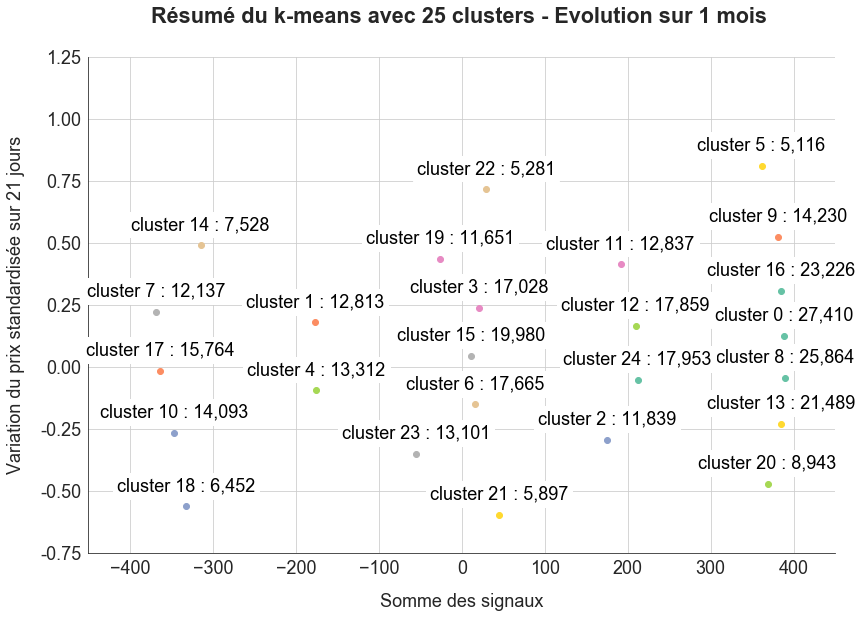

In [182]:
graph21b = sfg.MyGraph(title="Résumé du k-means avec 25 clusters - Evolution sur 1 mois")
for i in np.arange(len(kmeans21b.df_centroids)):
    graph21b.add_plot(x_values=kmeans21b.df_centroids.iloc[i].somme_signaux, \
                     y_values=kmeans21b.df_centroids.iloc[i].variation_21_standard, \
                     label=kmeans21b.df_centroids.index[i], marker='o', linestyle='', with_grid='both')
    graph21b.add_text(x_coord=kmeans21b.df_centroids.iloc[i].somme_signaux, \
                     y_coord=kmeans21b.df_centroids.iloc[i].variation_21_standard+0.12, \
                     text="{} : {:,.0f}".format(kmeans21b.df_centroids.index[i],kmeans21b.df_centroids.iloc[i].nombre_individus), \
                     backgroundcolor=(1,1,1))
graph21b.set_axe('x', label="Somme des signaux", tick_min=-450, tick_max=450)
graph21b.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph21b.fig, graph21b.ax
#plt.savefig("kmeans21_25centroids.png")
plt.show()

La lecture avec 25 clusters est difficile. J'essaie avec 15 clusters (matrice 3x5 espérée).

In [183]:
kmeans21.define_n_clusters(15)
kmeans21.calculate_clusters_centroids()
resultats_kmeans21 = kmeans21.df_data_clusters.copy()
resultats_kmeans21.head()

,somme_signaux,variation_21_standard,cluster
0,0,0.082215,13
1,0,0.239948,6
2,0,0.198553,6
3,0,0.097800,13
4,0,0.091391,13


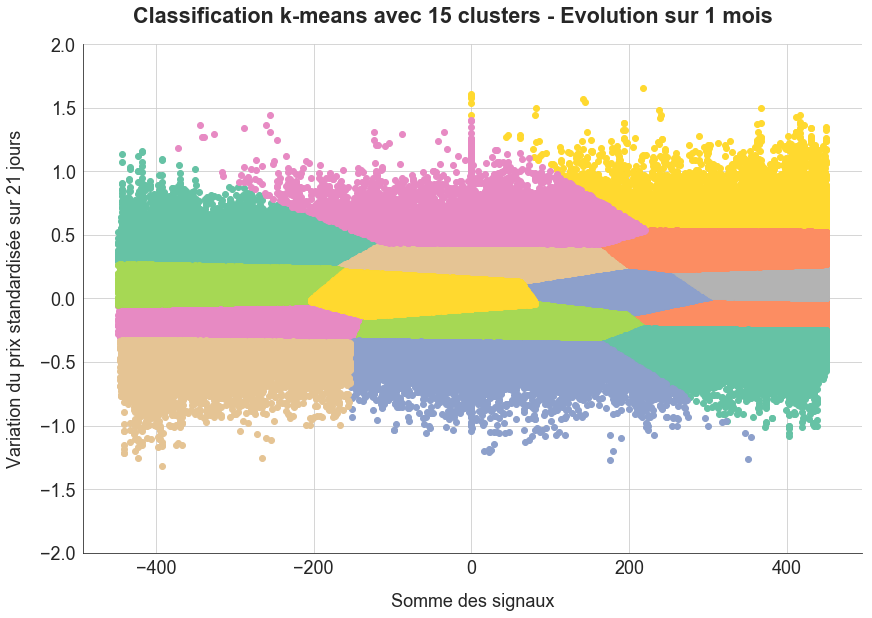

In [184]:
graph21 = sfg.MyGraph(title="Classification k-means avec 15 clusters - Evolution sur 1 mois")
for i in np.sort(resultats_kmeans21.cluster.unique()):
    graph21.add_plot(x_values=resultats_kmeans21[resultats_kmeans21.cluster==i].somme_signaux, \
                     y_values=resultats_kmeans21[resultats_kmeans21.cluster==i].variation_21_standard, \
                     label="Cluster {}".format(i), marker='o', linestyle='', with_grid='both')
graph21.set_axe('x', label="Somme des signaux")
graph21.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-2.0, tick_max=2.0)
#graph21.set_legend(loc='lower center', ncol=5)
fig, ax = graph21.fig, graph21.ax
#plt.savefig("kmeans21_15partitions.png")
plt.show()

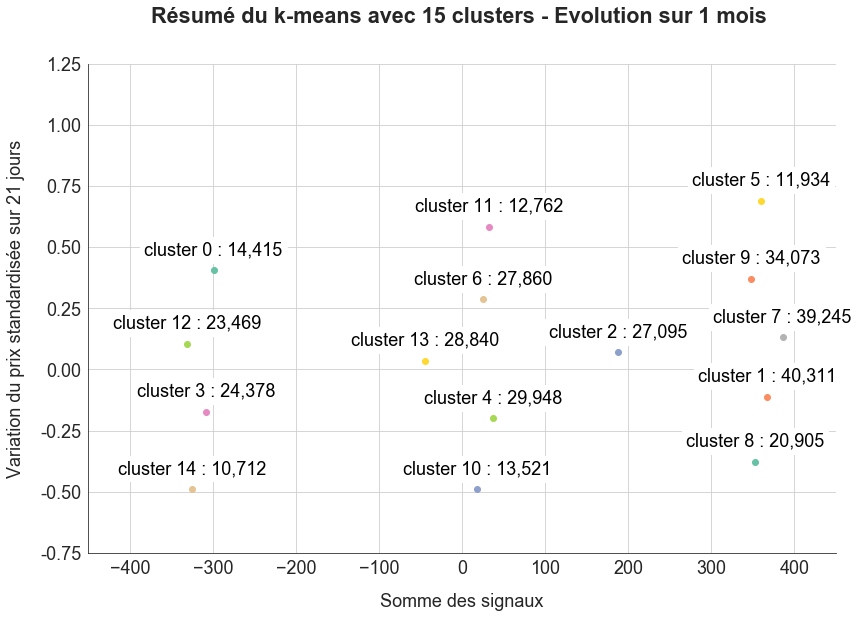

In [185]:
graph21b = sfg.MyGraph(title="Résumé du k-means avec 15 clusters - Evolution sur 1 mois")
for i in np.arange(len(kmeans21.df_centroids)):
    graph21b.add_plot(x_values=kmeans21.df_centroids.iloc[i].somme_signaux, \
                     y_values=kmeans21.df_centroids.iloc[i].variation_21_standard, \
                     label=kmeans21.df_centroids.index[i], marker='o', linestyle='', with_grid='both')
    graph21b.add_text(x_coord=kmeans21.df_centroids.iloc[i].somme_signaux, \
                     y_coord=kmeans21.df_centroids.iloc[i].variation_21_standard+0.12, \
                     text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
                     backgroundcolor=(1,1,1))
graph21b.set_axe('x', label="Somme des signaux", tick_min=-450, tick_max=450)
graph21b.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
#graph21b.set_legend(loc='lower center', ncol=5)
fig, ax = graph21b.fig, graph21b.ax
#plt.savefig("kmeans21_15centroids.png")
plt.show()

L'analyse est plus évidente et aisée avec 10 clusters. Aussi, je garde l'analyse du partitionnement en 10 clusters.

Je sauvegarde mes données d'analyse en y ajoutant le cluster obtenu avec le partitionnement.

In [186]:
kmeans21.define_n_clusters(10)
kmeans21.calculate_clusters_centroids()
resultats_kmeans21 = kmeans21.df_data_clusters.copy()
resultats_kmeans21.head()

,somme_signaux,variation_21_standard,cluster
0,0,0.082215,2
1,0,0.239948,8
2,0,0.198553,2
3,0,0.097800,2
4,0,0.091391,2


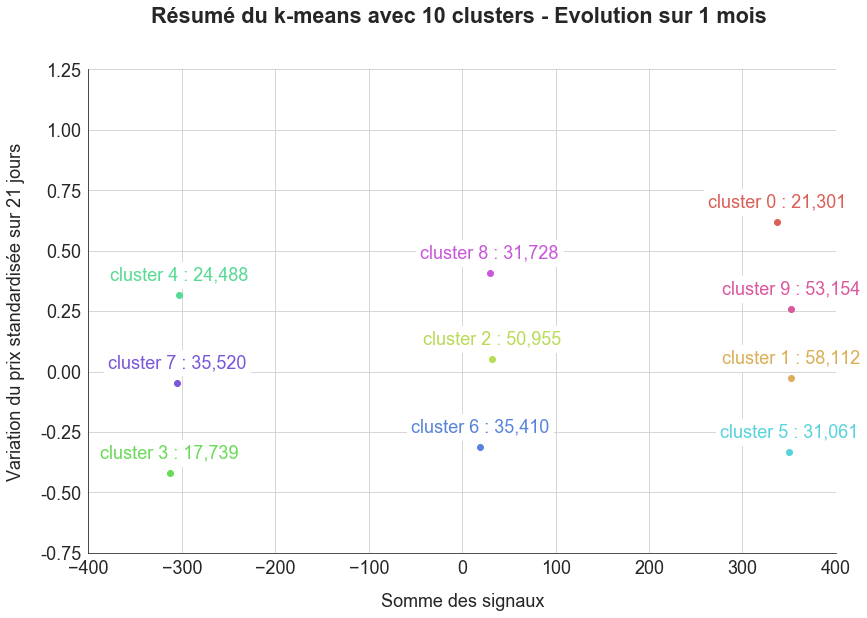

In [187]:
graph21b = sfg.MyGraph(title="Résumé du k-means avec 10 clusters - Evolution sur 1 mois")
for i in np.arange(len(kmeans21.df_centroids)):
    graph21b.add_plot(x_values=kmeans21.df_centroids.iloc[i].somme_signaux, \
         y_values=kmeans21.df_centroids.iloc[i].variation_21_standard, \
         label=kmeans21.df_centroids.index[i], color=liste_10couleurs[i], \
         marker='o', linestyle='', with_grid='both')
    graph21b.add_text(x_coord=kmeans21.df_centroids.iloc[i].somme_signaux, \
         y_coord=kmeans21.df_centroids.iloc[i].variation_21_standard+0.12, \
         text="{} : {:,.0f}".format(kmeans21.df_centroids.index[i],kmeans21.df_centroids.iloc[i].nombre_individus), \
         color=liste_10couleurs[i], backgroundcolor=(1,1,1))
graph21b.set_axe('x', label="Somme des signaux", tick_min=-400, tick_max=400)
graph21b.set_axe('y', label="Variation du prix standardisée sur 21 jours", tick_min=-0.75, tick_max=1.25, tick_step=0.25, tick_labels_format=':.2f')
fig, ax = graph21b.fig, graph21b.ax
plt.savefig("kmeans21_10centroids.png")
plt.show()

In [188]:
top_cluster21 = 0

J'étudie le pourcentage de positions gagnantes.  
Je considère qu'aucune position n'est prise pour les clusters dont la somme des signaux proche de 0 (clusters 2, 6 et 8). Les positions gagnantes sont celles des clusters 0, 3 et 9, parmi lesquelles les positions super-gagnantes sont celles du cluster 0.

In [199]:
nombre_total = kmeans21.df_centroids.nombre_individus.sum() - \
                kmeans21.df_centroids.iloc[2].nombre_individus - \
                kmeans21.df_centroids.iloc[6].nombre_individus - \
                kmeans21.df_centroids.iloc[8].nombre_individus
nombre_gagnant = kmeans21.df_centroids.iloc[0].nombre_individus + \
                kmeans21.df_centroids.iloc[3].nombre_individus + \
                kmeans21.df_centroids.iloc[9].nombre_individus
nombre_super_gagnant = kmeans21.df_centroids.iloc[0].nombre_individus
print("% de positions gagnantes = {:.2%} - dont super-gagnantes = {:.2%}".format(nombre_gagnant / nombre_total, nombre_super_gagnant / nombre_total))

% de positions gagnantes = 38.20% - dont super-gagnantes = 8.82%


38.2% des positions sont gagnantes, ce qui est un bon ratio pour un système suiveur de tendance. Les positions du cluster 0 (8.8% du total des positions prises) sont celles qui m'intéressent la plus car elles génèrent les plus gros gains.

In [189]:
analyse_21jours.head()

,category_name,contract_id,dateref,somme_signaux,variation_21_standard
0,Currencies,1,1989-11-01,0,0.082215
1,Currencies,1,1989-11-02,0,0.239948
2,Currencies,1,1989-11-03,0,0.198553
3,Currencies,1,1989-11-06,0,0.097800
4,Currencies,1,1989-11-07,0,0.091391


In [190]:
kmeans21.df_clusters.head()

,cluster
0,2
1,8
2,2
3,2
4,2


In [191]:
data21 = analyse_21jours.dropna().merge(kmeans21.df_clusters, how='left', left_index=True, right_index=True)
data21["top_cluster"] = data21.cluster == top_cluster21
data21.head()

,category_name,contract_id,dateref,somme_signaux,variation_21_standard,cluster,top_cluster
0,Currencies,1,1989-11-01,0,0.082215,2,False
1,Currencies,1,1989-11-02,0,0.239948,8,False
2,Currencies,1,1989-11-03,0,0.198553,2,False
3,Currencies,1,1989-11-06,0,0.097800,2,False
4,Currencies,1,1989-11-07,0,0.091391,2,False


In [192]:
data42 = analyse_42jours.dropna().merge(kmeans42.df_clusters, how='left', left_index=True, right_index=True)
data42["top_cluster"] = data42.cluster == top_cluster42
data42.head()

,category_name,contract_id,dateref,somme_signaux,variation_42_standard,cluster,top_cluster
0,Currencies,1,1989-11-01,0,0.376857,6,False
1,Currencies,1,1989-11-02,0,0.338517,6,False
2,Currencies,1,1989-11-03,0,0.330530,6,False
3,Currencies,1,1989-11-06,0,0.275066,6,False
4,Currencies,1,1989-11-07,0,0.314145,6,False


In [193]:
data64 = analyse_64jours.dropna().merge(kmeans64.df_clusters, how='left', left_index=True, right_index=True)
data64["top_cluster"] = data64.cluster == top_cluster64
data64.head()

,category_name,contract_id,dateref,somme_signaux,variation_64_standard,cluster,top_cluster
0,Currencies,1,1989-11-01,0,0.057156,4,False
1,Currencies,1,1989-11-02,0,0.105039,4,False
2,Currencies,1,1989-11-03,0,-0.046118,4,False
3,Currencies,1,1989-11-06,0,-0.149538,4,False
4,Currencies,1,1989-11-07,0,-0.227753,4,False


<a id='1_5'></a>

### 1.5. Sauvegarde des dataframes pour la suite du projet

In [194]:
data21.to_csv("data21jours.csv")
data42.to_csv("data42jours.csv")
data64.to_csv("data64jours.csv")

In [195]:
agreg_contrat_indicateur.to_csv("agreg_contrat_indicateur.csv")
agreg_contrat_horizon.to_csv("agreg_contrat_horizon.csv")
agreg_contrat_precis.to_csv("agreg_contrat_precis.csv")